# Research data supporting "A coming of age for many-body methods: Achieving consensus with experiments for CO on MgO"

This notebook accompanies our paper: **A coming of age for reference many-body methods in surface chemistry: Achieving consensus between theory and experiments for CO on MgO**. It can be found on GitHub at https://github.com/benshi97/Data_CO_on_MgO and explored interactively on [Colab](https://colab.research.google.com/github/benshi97/Data_CO_on_MgO/blob/main/analyse.ipynb).

### Abstract

The adsorption energy of a molecule onto the surface of a material underpins a wide array of applications, spanning heterogeneous catalysis, gas storage and many more. It is the key quantity where experimental measurements and theoretical calculations meet, with agreement being necessary for reliable predictions of reaction rates and mechanisms. The prototypical molecule-surface system is CO adsorbed on MgO, but despite intense scrutiny from theory and experiment, there is still no consensus on its adsorption energy. In particular, the large cost of accurate many-body methods makes reaching converged theoretical estimates difficult, generating a wide range of values. In this work, we address this challenge, leveraging the latest advances in diffusion Monte Carlo (DMC) and coupled cluster theory [CCSD(T)], to obtain accurate predictions for CO on MgO. These reliable theoretical estimates allow us to evaluate the inconsistencies in published temperature programmed desorption experiments, revealing that they arise from variations in employed pre-exponential factors. Using this insight, we derive new experimental estimates of the (electronic) adsorption energy from a more precise pre-exponential factor. With this effort, we are able to reach consensus between multiple theoretical calculations and multiple experiments for the first time. In addition, we show that our recently developed cluster-based CCSD(T) approach provides a low cost route towards achieving accurate adsorption energies. This sets the stage for affordable and reliable theoretical predictions of reaction mechanisms and rates to guide the realization of new catalysts and gas storage materials.


## Contents
* [Table S1 and Figure 1 - Past CO on MgO *E*<sub>ads</sub> and Current Work](#tables1fig1)
* [Table S2 and S3 - Validating the revPBE-D4 geometry and Computing its $\Delta_\textrm{geom}$](#tables2s3)
* [Table S4 and S5 - Periodic CCSD(T) Convergence](#tables4)
* [Table S6 - Periodic DMC Convergence](#tables6)
* [Table S7 - DFT Convergence](#tables7)
* [Table S9 to S11 and Figure 2 - SKZCAM Cluster CCSD(T) Convergence](#tables9-s11)
* [Table S8 - Final periodic CCSD(T), periodic DMC and cluster CCSD(T) $E_\textrm{ads}$ and their individual contributions](#tables8)
* [Table S12 - Analysis of previous computational work on CO on MgO](#tables12)
* [Table S13 - Computation of zero-point energy and thermal contribution terms to convert $H_\textrm{ads}$ to $E_\textrm{ads}$](#tables13)
* [Figure 3 and S1 - Converting previous experiment $H_\textrm{ads}$ or $E_\textrm{act}$ (for TPD) to $E_\textrm{ads}$](#fig3)
* [Table S14 - Final best estimate of TPD experimental adsorption energies](#tables14)
* [Table S15 - Effect of CO coverage on $E_\textrm{ads}$](#tables15)


In [1]:
# Check if we are in Google Colab environment
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# If in Google Colab, install the necessary data and set up the necessary environment
if IN_COLAB == True:
    !rm -rf /content/Data_CO_on_MgO-main /content/main.zip
    !wget https://github.com/benshi97/Data_CO_on_MgO/archive/refs/heads/main.zip
    !unzip /content/main.zip
    ! apt install ase
    !pip install pyblock datetime
    %pwd
    %cd /content/Data_CO_on_MgO-main

In [2]:
from ase import io
from ase.units import mol, kcal, kJ, Hartree
import pandas as pd
import pyblock
from Scripts.jup_plot import *
from Scripts.cluster_scripts import *
import Scripts.extrapolate as extrapolate

usetex = False

# Initialize the dictionary of final adsorption energies and the individual contributions to each adsorption energy
ene_final = np.load("Data/Misc/methods_eads.npy", allow_pickle="TRUE").item()

# Get the best estimate of the experimental adsorption energies
best_expt_eads = np.loadtxt("Data/Misc/best_expt.txt")

# List of DFT functionals used in this study
dft_functionals = [
    "01_PBE-D2-Ne",
    "02_revPBE-D4",
    "03_vdW-DF",
    "04_rev-vdW-DF2",
    "05_PBE0-D4",
    "06_B3LYP-D2-Ne",
]

# Some basic conversion factors
kcalmol_to_meV = kcal / mol * 1000
kjmol_to_meV = kJ / mol * 1000
mha_to_meV = Hartree

<a id='tables1fig1'></a>
## Table S1 and Figure 1

In [3]:
# Create a dictionary of the experimental and theoretical adsorption energies taken or converted from their original literature sources
# Experiments go as [Adsorption enthalpy, experiment_type,year,details]
experimental_hads = {
    'Furuyama et al.': [-3.8*kcalmol_to_meV,'Isothermal adsorption',1978,''],
    'Paukshtis et al.': [-15*kjmol_to_meV,'IR spectroscopy',1981,''],
    'Henry et al.': [-420,'Auger spectroscopy',1991,''],
    'He et al.': [-9.9*kcalmol_to_meV,'Isothermal adsorption',1992,''],
    'Wichtendahl et al.': [-140,'Thermal programmed desorption',1999,'Eact, nu=13, low 0.3 ML coverage'],
    'Dohnalek et al.': [-18.5*kjmol_to_meV,'Thermal programmed desorption',2001,'Eact, nu=15, low 0.125 ML coverage'],
    'Spoto et al.1': [-11*kjmol_to_meV,'FTIR spectroscopy',2003,'MgO smoke'],
    'Spoto et al.2': [-12.5*kjmol_to_meV,'FTIR spectroscopy',2004,'MgO smoke'],
    'Sterrer et al.': [-15*kjmol_to_meV,'Thermal programmed desorption',2006,'Eact, nu=13, high CO coverage']
}

# Computation goes as [Adsorption energy, method,year,details]
computational_eads = {
    'Ugliengo et al.': [-12.7*kjmol_to_meV,'cluster MP2:B3LYP',2002,'HL:LL mechanical embedding'],
    'Herschend et al.': [-124,'cluster MP2',2006,'Electrostatic embedding'],
    'Qin et al.': [-110,'cluster CISD',2008,'Electrostatic embedding'],
    'Staemmler': [-124,'cluster CEPA',2011,'Method of local increments'],
    'Boese et al.': [-21*kjmol_to_meV,'cluster MP2+deltaCC:PBE-D2',2013,'HL:LL mechanical embedding'],
    'Li et al.': [-3*kjmol_to_meV,'cluster MP2',2015,'Gas phase cluster-in-molecule approach'],
    'Bajdich et al.': [-310,'periodic RPA',2015,'Supercell approach'],
    'Heuser et al.': [ -15.0*mha_to_meV, 'cluster CC2',2016,'Wave-function frozen-density embedding'],
    'Mazheika and Levchenko1': [70,'cluster CCSD(T)',2016,'Electrostatic embedding'],
    'Mazheika and Levchenko2': [-10,'cluster RPA',2016,'Electrostatic embedding, RPA+rSE+SOSEX'],
    # 'Alessio et al.1': [-21.7*kjmol_to_meV,'cluster MP2+deltaCC:B3LYP-D2',2019,'HL:LL mechanical embedding'],
    'Alessio et al.2': [-22.2*kjmol_to_meV,'periodic LMP2+deltaCC',2019,'Supercell with cluster deltaCC'],
    'Mitra et al.': [-9.18*kcalmol_to_meV,'periodic CCSD',2022,'Supercell approach']
}

# Getting the -29 meV thermal correction calculated by DFT and also the RT term
thermal_correction = np.genfromtxt('Data/Misc/thermal_corr.txt')[0,0]
rt = np.genfromtxt('Data/Misc/thermal_corr.txt')[3,0]


In [4]:
# Write the experimental and computational adsorption energies into a dataframe
df = pd.DataFrame(experimental_hads).T
df = df.reset_index()
df.columns = ['Reference','Hads (meV)','Method','Year','Details']
df['Hads (meV)'] = df['Hads (meV)'].apply(lambda x: round(x))

eads_list = []
for i in experimental_hads:
    if 'desorption' in experimental_hads[i][1]:
        eads_list += [experimental_hads[i][0] - thermal_correction - 0.5*rt]
    else:
        eads_list += [experimental_hads[i][0] - thermal_correction]


df['Eads (meV)'] = eads_list
df['Eads (meV)'] = df['Eads (meV)'].round().astype(int)

# df['Hads (meV)'] - thermal_correction
# df['Details'] = pd.Series(dtype='str')
df = df[['Reference','Eads (meV)','Hads (meV)','Method','Year','Details']]

df1 = pd.DataFrame(computational_eads).T
df1 = df1.reset_index()
df1.columns = ['Reference','Eads (meV)','Method','Year','Details']
df1['Eads (meV)'] = df1['Eads (meV)'].apply(lambda x: round(x))
df1['Hads (meV)'] = df1['Eads (meV)'] + thermal_correction
df1['Hads (meV)'] = df1['Hads (meV)'].apply(lambda x: round(x))

df1 = df1[['Reference','Eads (meV)','Hads (meV)','Method','Year','Details']]
df1

df_final = pd.concat([df,df1])
# df_final.to_clipboard( index=False, excel=True,sep=',')
df_final


,Reference,Eads (meV),Hads (meV),Method,Year,Details
0,Furuyama et al.,-194,-165,Isothermal adsorption,1978,
1,Paukshtis et al.,-185,-155,IR spectroscopy,1981,
2,Henry et al.,-449,-420,Auger spectroscopy,1991,
3,He et al.,-459,-429,Isothermal adsorption,1992,
4,Wichtendahl et al.,-172,-140,Thermal programmed desorption,1999,"Eact, nu=13, low 0.3 ML coverage"
5,Dohnalek et al.,-224,-192,Thermal programmed desorption,2001,"Eact, nu=15, low 0.125 ML coverage"
6,Spoto et al.1,-143,-114,FTIR spectroscopy,2003,MgO smoke
7,Spoto et al.2,-159,-130,FTIR spectroscopy,2004,MgO smoke
8,Sterrer et al.,-187,-155,Thermal programmed desorption,2006,"Eact, nu=13, high CO coverage"
0,Ugliengo et al.,-132,-103,cluster MP2:B3LYP,2002,HL:LL mechanical embedding


/home/shixubenjamin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


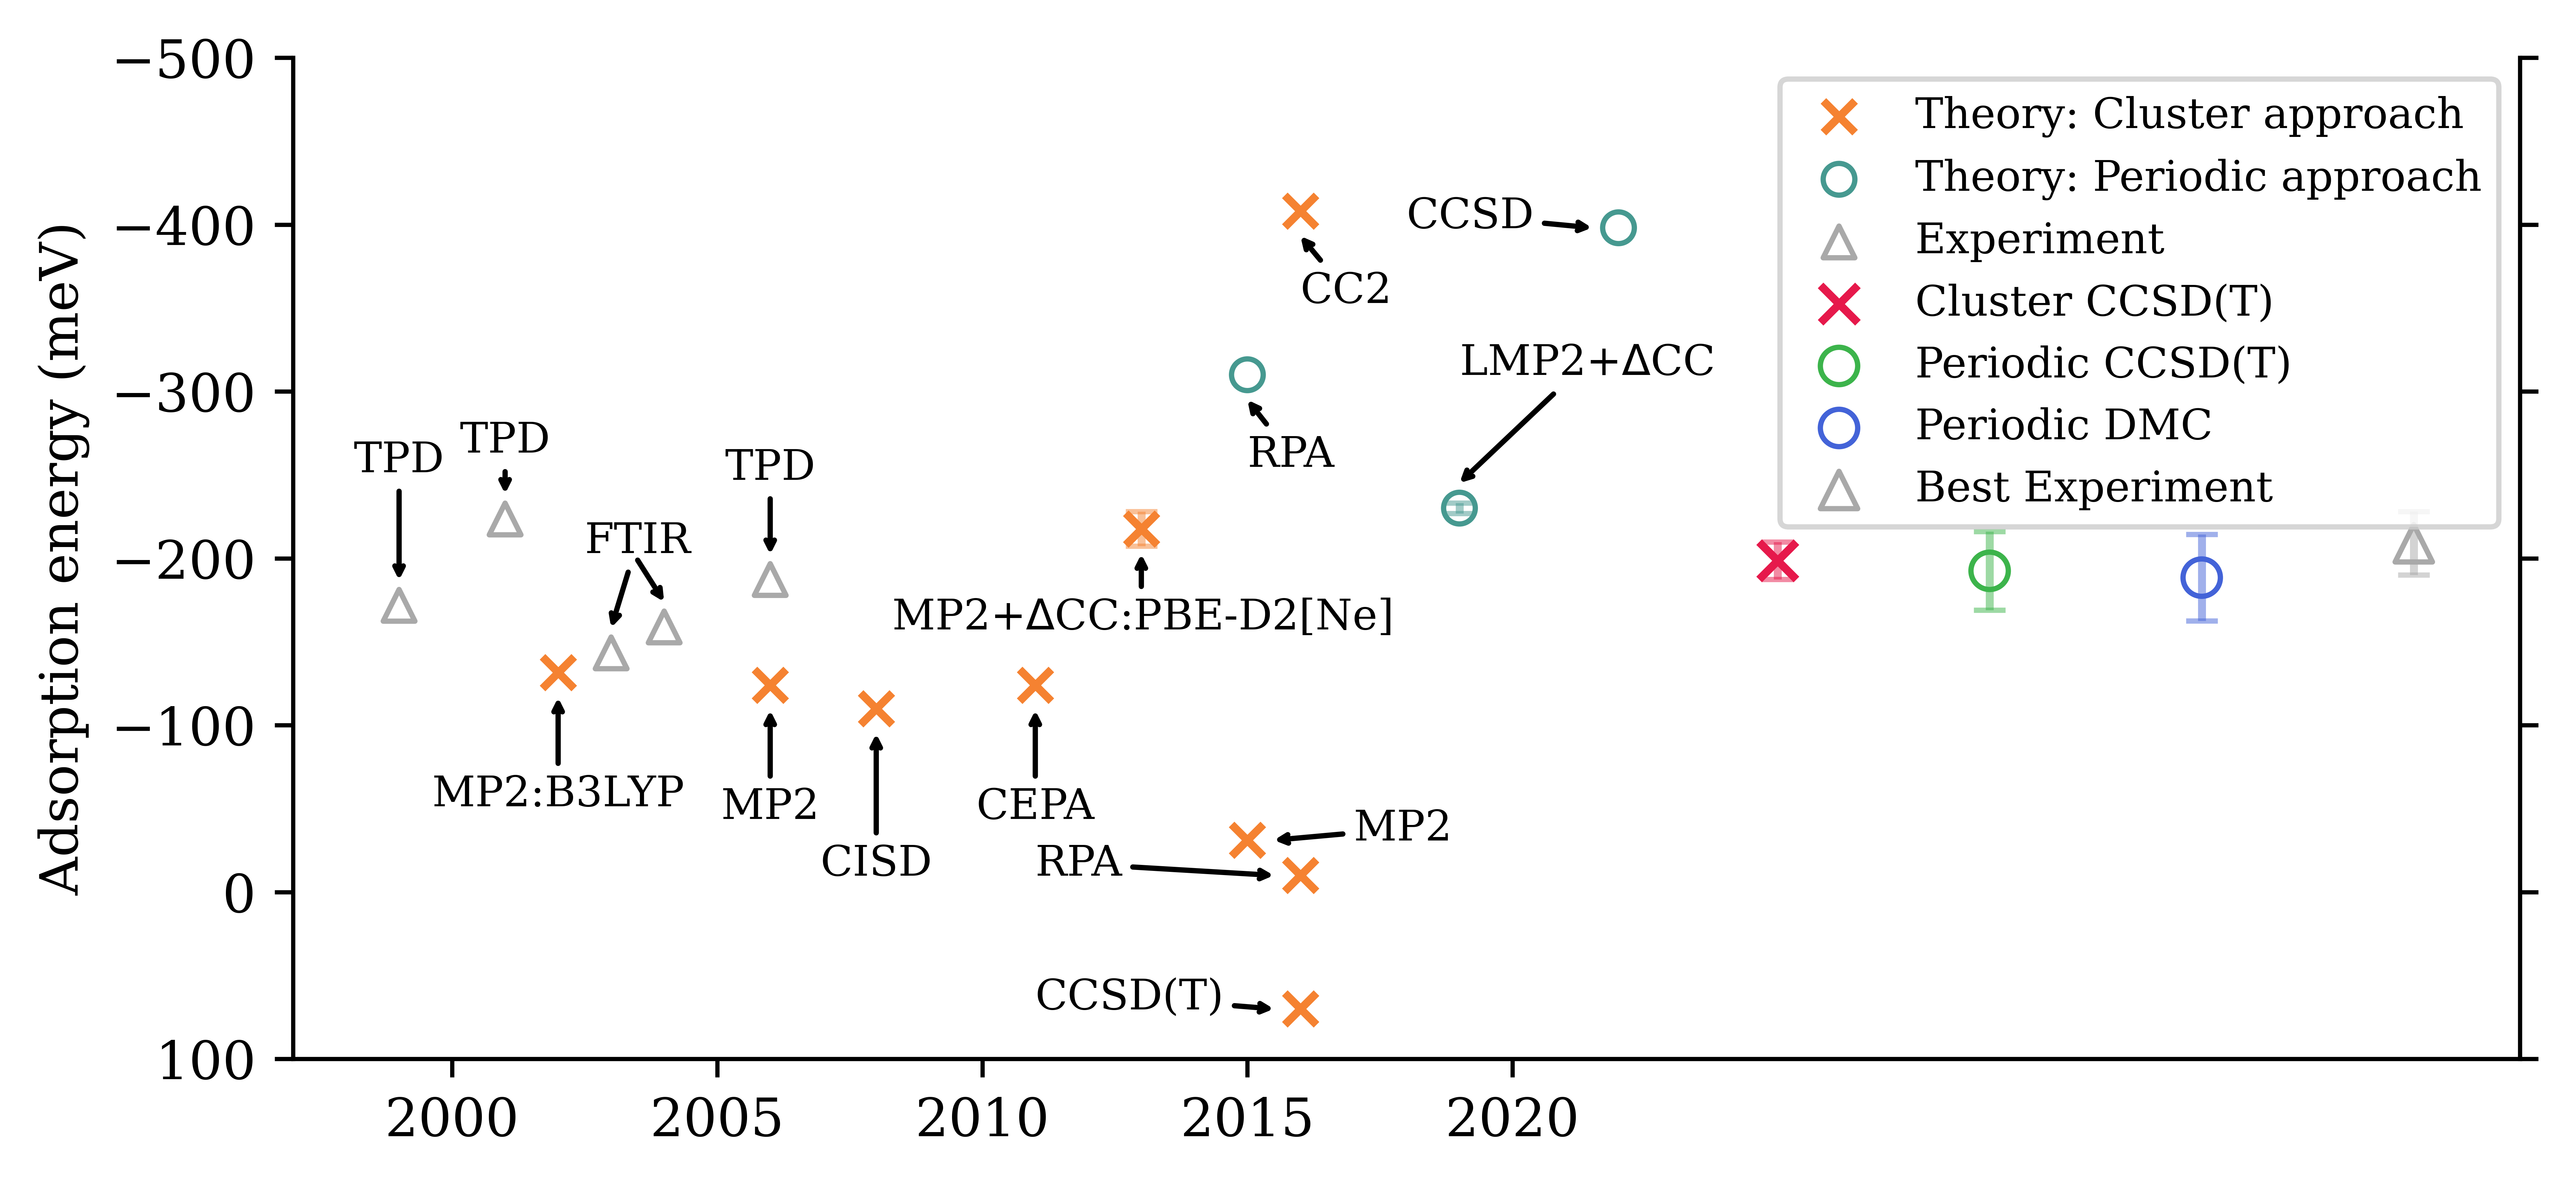

In [5]:
# List to store experimental energies and times
exp_energies = []
exp_time = []

# Loop through different experimental sources
for i in ['Wichtendahl et al.','Dohnalek et al.','Spoto et al.1','Spoto et al.2','Sterrer et al.']:
    if 'desorption' in experimental_hads[i][1]:
        exp_energies += [experimental_hads[i][0] - thermal_correction - 2.5]
    else:
        exp_energies += [experimental_hads[i][0] - thermal_correction]
    exp_time += [experimental_hads[i][2]]


# Separate computational data based on approach type (cluster or periodic)
cwft_cluster_time = [computational_eads[x][2] for x in computational_eads if 'cluster' in computational_eads[x][1]]
cwft_cluster_energies = [computational_eads[x][0] for x in computational_eads if 'cluster' in computational_eads[x][1]]

cwft_periodic_time = [computational_eads[x][2] for x in computational_eads if 'periodic' in computational_eads[x][1]]
cwft_periodic_energies = [computational_eads[x][0] for x in computational_eads if 'periodic' in computational_eads[x][1]]


# Create a figure and subplots
fig, axs = plt.subplots(figsize=(6.66,3),dpi=1200, sharey=True,constrained_layout=True)

# Arrow properties
prop = dict(arrowstyle="->,head_width=0.1,head_length=0.2",
            shrinkA=0,shrinkB=0)

# Scatter plot for different data points
axs.scatter(cwft_cluster_time,cwft_cluster_energies,marker="x",color=color_dict['orange'],edgecolors='none',label='Theory: Cluster approach')
axs.scatter(cwft_periodic_time,cwft_periodic_energies,marker="o",color=color_dict['teal'],facecolor='none',label='Theory: Periodic approach')
axs.scatter(exp_time,exp_energies,marker="^",color=color_dict['grey'],facecolor='none',label='Experiment')

if usetex == True:
    # Annotate experimental data points with labels
    for index, i in enumerate(exp_time):
        if i == 1999:
            axs.annotate("TPD" + r'\textsuperscript{l}',xy=(1999,exp_energies[index]-15), xytext=(1999,exp_energies[index]-80),arrowprops=prop,ha='center',fontsize=8)    
        if i == 2001:
            axs.annotate("TPD" + r'\textsuperscript{m}',xy=(i,exp_energies[index]-15), xytext=(i,exp_energies[index]-40),arrowprops=prop,ha='center',fontsize=8)   
        if i == 2006:
            axs.annotate("TPD" + r'\textsuperscript{p}',xy=(i,exp_energies[index]-15), xytext=(i,exp_energies[index]-60),arrowprops=prop,ha='center',fontsize=8)
        if i == 2003:
            axs.annotate("FTIR" + r'\textsuperscript{n,o}',xy=(i,exp_energies[index]-15), xytext=(i+0.5,exp_energies[index]-60),arrowprops=prop,ha='center',fontsize=8)
        if i == 2004:
            axs.annotate('',xy=(i,exp_energies[index]-15), xytext=(i-0.5,exp_energies[index]-40),arrowprops=prop,ha='center',fontsize=8)

    # Annotations for computational data
    for i in ['Ugliengo et al.']:
        axs.annotate("{0}".format(computational_eads[i][1].split()[1]) + r'\textsuperscript{a}',xy=(computational_eads[i][2],computational_eads[i][0]+15), xytext=(computational_eads[i][2],computational_eads[i][0] + 80),arrowprops=prop,ha='center',fontsize=8)

    for i in ['Herschend et al.']:
        axs.annotate("{0}".format(computational_eads[i][1].split()[1]) + r'\textsuperscript{b}',xy=(computational_eads[i][2],computational_eads[i][0]+15), xytext=(computational_eads[i][2],computational_eads[i][0] + 80),arrowprops=prop,ha='center',fontsize=8)

    for i in ['Staemmler']:
        axs.annotate("{0}".format(computational_eads[i][1].split()[1]) + r'\textsuperscript{d}',xy=(computational_eads[i][2],computational_eads[i][0]+15), xytext=(computational_eads[i][2],computational_eads[i][0] + 80),arrowprops=prop,ha='center',fontsize=8)

    for i in ['Qin et al.']:
        axs.annotate("{0}".format(computational_eads[i][1].split()[1]) + r'\textsuperscript{c}',xy=(computational_eads[i][2],computational_eads[i][0]+15), xytext=(computational_eads[i][2],computational_eads[i][0] + 100),arrowprops=prop,ha='center',fontsize=8)

    for i in ['Mitra et al.']:
        axs.annotate("{0}".format(computational_eads[i][1].split()[1])+ r'\textsuperscript{k}',xy=(computational_eads[i][2]-0.5,computational_eads[i][0]), xytext=(computational_eads[i][2]-4,computational_eads[i][0]),arrowprops=prop,ha='left',fontsize=8)

    for i in ['Heuser et al.']:
        axs.annotate("{0}".format(computational_eads[i][1].split()[1]) + r'\textsuperscript{i}',xy=(computational_eads[i][2],computational_eads[i][0]+15), xytext=(computational_eads[i][2],computational_eads[i][0]+55),arrowprops=prop,ha='left',fontsize=8)

    for i in ['Bajdich et al.']:
        axs.annotate("{0}".format(computational_eads[i][1].split()[1]) + r'\textsuperscript{g}',xy=(computational_eads[i][2],computational_eads[i][0]+15), xytext=(computational_eads[i][2],computational_eads[i][0]+55),arrowprops=prop,ha='left',fontsize=8)

    for i in ['Mazheika and Levchenko1']:
        axs.annotate("{0}".format(computational_eads[i][1].split()[1])+ r'\textsuperscript{j}',xy=(computational_eads[i][2]-0.5,computational_eads[i][0]), xytext=(computational_eads[i][2]-5,computational_eads[i][0]),arrowprops=prop,ha='left',fontsize=8)

    for i in ['Mazheika and Levchenko2']:
        axs.annotate("{0}".format(computational_eads[i][1].split()[1])+ r'\textsuperscript{j}',xy=(computational_eads[i][2]-0.5,computational_eads[i][0]), xytext=(computational_eads[i][2]-5,computational_eads[i][0]),arrowprops=prop,ha='left',fontsize=8)

    for i in ['Li et al.']:
        axs.annotate("{0}".format(computational_eads[i][1].split()[1]) +  r'\textsuperscript{h}',xy=(computational_eads[i][2]+0.5,computational_eads[i][0]), xytext=(computational_eads[i][2]+2,computational_eads[i][0]),arrowprops=prop,ha='left',fontsize=8)

    # for i in ['Alessio et al.1']:
    #     axs.annotate(r'MP2+$\Delta$CC:B3LYP-D2[Ne]'  + r'\textsuperscript{f}',xy=(computational_eads[i][2],computational_eads[i][0]), xytext=(computational_eads[i][2],computational_eads[i][0]+65),arrowprops=prop,ha='center',fontsize=8)

    for i in ['Alessio et al.2']:
        axs.annotate(r'LMP2+$\Delta$CC'.format(computational_eads[i][1]) + r'\textsuperscript{f}',xy=(computational_eads[i][2],computational_eads[i][0]-15), xytext=(computational_eads[i][2],computational_eads[i][0]-80),arrowprops=prop,ha='left',fontsize=8)
        axs.errorbar(computational_eads[i][2],computational_eads[i][0],yerr=0.3*kjmol_to_meV,fmt='o',markersize=0,capsize=3,color=color_dict['teal'],markerfacecolor='none',alpha=0.5)

    for i in ['Boese et al.']:
        axs.annotate(r'MP2+$\Delta$CC:PBE-D2[Ne]'  + r'\textsuperscript{e}',xy=(computational_eads[i][2],computational_eads[i][0]+15), xytext=(computational_eads[i][2],computational_eads[i][0]+60),arrowprops=prop,ha='center',fontsize=8)
        axs.errorbar(computational_eads[i][2],computational_eads[i][0],yerr=1.0*kjmol_to_meV,fmt='^',markersize=0,capsize=3,color=color_dict['orange'],markerfacecolor='none',alpha=0.5)

    # Error bars for specific data points coming from this work
    axs.errorbar(2025,ene_final['Cluster CCSD(T)']['Final'][0],yerr=ene_final['Cluster CCSD(T)']['Final'][1],fmt='x',markersize=0,capsize=3,color=color_dict['red'],markerfacecolor='none',alpha=0.5) #,label='SKZCAM-CCSD(T)')
    axs.errorbar(2029,ene_final['Periodic CCSD(T)']['Final'][0],yerr=ene_final['Periodic CCSD(T)']['Final'][1],fmt='o',markersize=0,capsize=3,color=color_dict['green'],markerfacecolor='none',alpha=0.5) #,label='p-CCSD(T)')
    axs.errorbar(2033,ene_final['Periodic DMC']['Final'][0],yerr=ene_final['Periodic DMC']['Final'][1],fmt='o',markersize=0,capsize=3,color=color_dict['blue'],markerfacecolor='none',alpha=0.5) #,label='p-DMC')
    axs.errorbar(2037,best_expt_eads[0],yerr=best_expt_eads[1],fmt='^',markersize=0,capsize=3,color=color_dict['grey'],markerfacecolor='none',alpha=0.5) #,label='p-DMC')


    axs.scatter(2025,ene_final['Cluster CCSD(T)']['Final'][0],marker='x',s=50,color=color_dict['red'])
    axs.scatter(2029,ene_final['Periodic CCSD(T)']['Final'][0],marker='o',s=50,color=color_dict['green'],facecolor='none')
    axs.scatter(2033,ene_final['Periodic DMC']['Final'][0],marker='o',s=50,color=color_dict['blue'],facecolor='none')
    axs.scatter(2037,best_expt_eads[0],marker='^',s=50,color=color_dict['grey'],facecolor='none')

    axs.spines[[ 'top']].set_visible(False)

    axs.yaxis.set_ticks_position('both')

    axs.legend(loc=(0.1,0.75),frameon=True,fontsize=8)
else:
    # Same annotations but for non-TeX mode in Google Colab
    for index, i in enumerate(exp_time):
        if i == 1999:
            axs.annotate("TPD" ,xy=(1999,exp_energies[index]-15), xytext=(1999,exp_energies[index]-80),arrowprops=prop,ha='center',fontsize=8)    
        if i == 2001:
            axs.annotate("TPD" ,xy=(i,exp_energies[index]-15), xytext=(i,exp_energies[index]-40),arrowprops=prop,ha='center',fontsize=8)   
        if i == 2006:
            axs.annotate("TPD" ,xy=(i,exp_energies[index]-15), xytext=(i,exp_energies[index]-60),arrowprops=prop,ha='center',fontsize=8)
        if i == 2003:
            axs.annotate("FTIR" ,xy=(i,exp_energies[index]-15), xytext=(i+0.5,exp_energies[index]-60),arrowprops=prop,ha='center',fontsize=8)
        if i == 2004:
            axs.annotate('',xy=(i,exp_energies[index]-15), xytext=(i-0.5,exp_energies[index]-40),arrowprops=prop,ha='center',fontsize=8)


    for i in ['Ugliengo et al.']:
        axs.annotate("{0}".format(computational_eads[i][1].split()[1]) ,xy=(computational_eads[i][2],computational_eads[i][0]+15), xytext=(computational_eads[i][2],computational_eads[i][0] + 80),arrowprops=prop,ha='center',fontsize=8)

    for i in ['Herschend et al.']:
        axs.annotate("{0}".format(computational_eads[i][1].split()[1]) ,xy=(computational_eads[i][2],computational_eads[i][0]+15), xytext=(computational_eads[i][2],computational_eads[i][0] + 80),arrowprops=prop,ha='center',fontsize=8)

    for i in ['Staemmler']:
        axs.annotate("{0}".format(computational_eads[i][1].split()[1]) ,xy=(computational_eads[i][2],computational_eads[i][0]+15), xytext=(computational_eads[i][2],computational_eads[i][0] + 80),arrowprops=prop,ha='center',fontsize=8)

    for i in ['Qin et al.']:
        axs.annotate("{0}".format(computational_eads[i][1].split()[1]) ,xy=(computational_eads[i][2],computational_eads[i][0]+15), xytext=(computational_eads[i][2],computational_eads[i][0] + 100),arrowprops=prop,ha='center',fontsize=8)

    for i in ['Mitra et al.']:
        axs.annotate("{0}".format(computational_eads[i][1].split()[1]),xy=(computational_eads[i][2]-0.5,computational_eads[i][0]), xytext=(computational_eads[i][2]-4,computational_eads[i][0]),arrowprops=prop,ha='left',fontsize=8)

    for i in ['Heuser et al.']:
        axs.annotate("{0}".format(computational_eads[i][1].split()[1]) ,xy=(computational_eads[i][2],computational_eads[i][0]+15), xytext=(computational_eads[i][2],computational_eads[i][0]+55),arrowprops=prop,ha='left',fontsize=8)

    for i in ['Bajdich et al.']:
        axs.annotate("{0}".format(computational_eads[i][1].split()[1]) ,xy=(computational_eads[i][2],computational_eads[i][0]+15), xytext=(computational_eads[i][2],computational_eads[i][0]+55),arrowprops=prop,ha='left',fontsize=8)

    for i in ['Mazheika and Levchenko1']:
        axs.annotate("{0}".format(computational_eads[i][1].split()[1]),xy=(computational_eads[i][2]-0.5,computational_eads[i][0]), xytext=(computational_eads[i][2]-5,computational_eads[i][0]),arrowprops=prop,ha='left',fontsize=8)

    for i in ['Mazheika and Levchenko2']:
        axs.annotate("{0}".format(computational_eads[i][1].split()[1]),xy=(computational_eads[i][2]-0.5,computational_eads[i][0]), xytext=(computational_eads[i][2]-5,computational_eads[i][0]),arrowprops=prop,ha='left',fontsize=8)

    for i in ['Li et al.']:
        axs.annotate("{0}".format(computational_eads[i][1].split()[1]) ,xy=(computational_eads[i][2]+0.5,computational_eads[i][0]), xytext=(computational_eads[i][2]+2,computational_eads[i][0]),arrowprops=prop,ha='left',fontsize=8)

    # for i in ['Alessio et al.1']:
    #     axs.annotate(r'MP2+$\Delta$CC:B3LYP-D2[Ne]'  + r'\textsuperscript{f}',xy=(computational_eads[i][2],computational_eads[i][0]), xytext=(computational_eads[i][2],computational_eads[i][0]+65),arrowprops=prop,ha='center',fontsize=8)

    for i in ['Alessio et al.2']:
        axs.annotate(r'LMP2+$\Delta$CC'.format(computational_eads[i][1]),xy=(computational_eads[i][2],computational_eads[i][0]-15), xytext=(computational_eads[i][2],computational_eads[i][0]-80),arrowprops=prop,ha='left',fontsize=8)
        axs.errorbar(computational_eads[i][2],computational_eads[i][0],yerr=0.3*kjmol_to_meV,fmt='o',markersize=0,capsize=3,color=color_dict['teal'],markerfacecolor='none',alpha=0.5)

    for i in ['Boese et al.']:
        axs.annotate(r'MP2+$\Delta$CC:PBE-D2[Ne]',xy=(computational_eads[i][2],computational_eads[i][0]+15), xytext=(computational_eads[i][2],computational_eads[i][0]+60),arrowprops=prop,ha='center',fontsize=8)
        axs.errorbar(computational_eads[i][2],computational_eads[i][0],yerr=1.0*kjmol_to_meV,fmt='^',markersize=0,capsize=3,color=color_dict['orange'],markerfacecolor='none',alpha=0.5)


    axs.errorbar(2025,ene_final['Cluster CCSD(T)']['Final'][0],yerr=ene_final['Cluster CCSD(T)']['Final'][1],fmt='x',markersize=0,capsize=3,color=color_dict['red'],markerfacecolor='none',alpha=0.5)
    axs.errorbar(2029,ene_final['Periodic CCSD(T)']['Final'][0],yerr=ene_final['Periodic CCSD(T)']['Final'][1],fmt='o',markersize=0,capsize=3,color=color_dict['green'],markerfacecolor='none',alpha=0.5)
    axs.errorbar(2033,ene_final['Periodic DMC']['Final'][0],yerr=ene_final['Periodic DMC']['Final'][1],fmt='o',markersize=0,capsize=3,color=color_dict['blue'],markerfacecolor='none',alpha=0.5)
    axs.errorbar(2037,best_expt_eads[0],yerr=best_expt_eads[1],fmt='^',markersize=0,capsize=3,color=color_dict['grey'],markerfacecolor='none',alpha=0.5)


    axs.scatter(2025,ene_final['Cluster CCSD(T)']['Final'][0],marker='x',s=50,color=color_dict['red'],label='Cluster CCSD(T)')
    axs.scatter(2029,ene_final['Periodic CCSD(T)']['Final'][0],marker='o',s=50,color=color_dict['green'],facecolor='none' ,label='Periodic CCSD(T)')
    axs.scatter(2033,ene_final['Periodic DMC']['Final'][0],marker='o',s=50,color=color_dict['blue'],facecolor='none',label='Periodic DMC')
    axs.scatter(2037,best_expt_eads[0],marker='^',s=50,color=color_dict['grey'],facecolor='none',label='Best Experiment')
    axs.spines[[ 'top']].set_visible(False)
    axs.yaxis.set_ticks_position('both')
    axs.legend(loc='upper right',frameon=True,fontsize=8)


# Additional plot settings
axs.set_xlim([1997,2039])
axs.set_xticks([2000,2005,2010,2015,2020])
axs.set_ylim([100,-500])
if usetex == True:
    axs.set_ylabel(r'Adsorption energy $E_\textrm{ads}$ (meV)')
else:
    axs.set_ylabel('Adsorption energy (meV)')


plt.savefig('Figures/Fig_01.png') # Save the figure


<a id='tables2s3'></a>
## Table S2 and S3 - Validating the revPBE-D4 geometry and Computing its $\Delta_\textrm{geom}$

In [6]:
# Getting DeltaGeom for Table S3

# List of DFT functional names
dft_functionals = ['01_PBE-D2-Ne', '02_revPBE-D4', '03_vdW-DF', '04_rev-vdW-DF2', '05_PBE0-D4', '06_B3LYP-D2-Ne']

# Dictionary to store adsorption energies for true and approximate cases
ene_ads_list = {'Eads_True': {x: 0 for x in dft_functionals},
                'Eads_Approx': {x: 0 for x in dft_functionals}}

# Calculate the relaxation energy difference for a specific functional
for i in ['02_revPBE-D4']:
    # Obtain energies using the 'find_energy' function
    ad_slab = find_energy('Data/DFT/Eads/{0}/AD_SLAB/OUTCAR'.format(i), code_format='vasp')
    ad = find_energy('Data/DFT/Eads/{0}/AD/OUTCAR'.format(i), code_format='vasp')
    slab = find_energy('Data/DFT/Eads/{0}/SLAB/OUTCAR'.format(i), code_format='vasp')
    ad_fs = find_energy('Data/DFT/Eint/{0}/SLAB_FS/OUTCAR'.format(i), code_format='vasp')
    slab_fs = find_energy('Data/DFT/Eint/{0}/AD_FS/OUTCAR'.format(i), code_format='vasp')
    ad_slab_fs = find_energy('Data/DFT/Eint/{0}/AD_SLAB/OUTCAR'.format(i), code_format='vasp')
    e_relax = (slab_fs - slab) + (ad_fs - ad)

# Initialize a variable to store the squared sum of differences
squared_sum = 0

# Calculate adsorption energies and predictions for all DFT functionals
for i in dft_functionals:
    # Obtain energies using the 'find_energy' function
    ad_slab = find_energy('Data/DFT/Eads/{0}/AD_SLAB/OUTCAR'.format(i), code_format='vasp')
    ad = find_energy('Data/DFT/Eads/{0}/AD/OUTCAR'.format(i), code_format='vasp')
    slab = find_energy('Data/DFT/Eads/{0}/SLAB/OUTCAR'.format(i), code_format='vasp')
    ad_fs = find_energy('Data/DFT/Eint/{0}/SLAB_FS/OUTCAR'.format(i), code_format='vasp')
    slab_fs = find_energy('Data/DFT/Eint/{0}/AD_FS/OUTCAR'.format(i), code_format='vasp')
    ad_slab_fs = find_energy('Data/DFT/Eint/{0}/AD_SLAB/OUTCAR'.format(i), code_format='vasp')
    
    # Calculate various energy terms and convert to millielectronvolts (meV)
    eads = (ad_slab - ad - slab) * 1000
    eint = (ad_slab_fs - slab_fs - ad_fs) * 1000
    eads_pred = (ad_slab_fs - slab_fs - ad_fs + e_relax) * 1000
    
    # Store calculated energies in the dictionary
    ene_ads_list['Eads_True'][i] = eads
    ene_ads_list['Eads_Approx'][i] = eads_pred
    
    # Calculate squared differences and update squared_sum
    squared_sum += (eads - eads_pred) ** 2

# Create a DataFrame from the ene_ads_list dictionary
df = pd.DataFrame(ene_ads_list)

# Calculate and add the 'Difference' column to the DataFrame
df['Difference'] = df['Eads_True'] - df['Eads_Approx']

# Round the DataFrame values and convert to integers
df = df.round().astype(int)

# Print the DataFrame and RMSD
print(df)
print('RMSD:', round(np.sqrt(squared_sum / 5)))

# Calculate the delta geom values and store in a list
delta_geom = [e_relax * 1000, np.sqrt(squared_sum / 5)]


                Eads_True  Eads_Approx  Difference
01_PBE-D2-Ne         -228         -225          -4
02_revPBE-D4         -207         -207           0
03_vdW-DF            -232         -212         -20
04_rev-vdW-DF2       -266         -265          -1
05_PBE0-D4           -234         -241           7
06_B3LYP-D2-Ne       -149         -148          -1
RMSD: 10


In [7]:
# Getting the reference bond length from CCSD(T) calculations for Table S2

# Dictionary to store calculated bond energies for various methods and functionals
energy_bond_length = {"CCSD(T)_small": [],
                    "MP2_small": [],
                    "MP2_large": [],
                    "CCSD(T) final": [],
                    "01_PBE-D2-Ne": [],
                    "02_revPBE-D4": [],
                    "03_vdW-DF": [],
                    "04_rev-vdW-DF2": [],
                    "05_PBE0-D4": [],
                    "06_B3LYP-D2-Ne": []}

# List of bond lengths
r_list = ['2.36','2.38','2.40','2.41','2.42','2.43','2.44','2.45','2.46','2.47','2.48','2.49','2.50','2.51','2.52','2.53','2.54','2.55','2.56','2.57','2.58','2.60','2.62']

# Loop through each bond length
for j in r_list:
    # Initialize lists to store energy values for different methods
    ene_hf_small = []
    ene_hf_large = []
    ene_mp2_small = []
    ene_mp2_large = []
    ene_cc_small = []
    
    # Loop through different basis sets
    for k in ['TZ', 'QZ']:
        # Collect energies using different methods and basis sets
        ene_hf_small += [get_eads('Data/CC_Convergence/Bond_Dist/{0}/CC/{1}'.format(j, k), code_format='mrcc', typ='hf')]
        ene_mp2_small += [get_eads('Data/CC_Convergence/Bond_Dist/{0}/CC/{1}'.format(j, k), code_format='mrcc', typ='mp2')]
        ene_cc_small += [get_eads('Data/CC_Convergence/Bond_Dist/{0}/CC/{1}'.format(j, k), code_format='mrcc', typ='ccsdt')]
        ene_hf_large += [get_eads('Data/CC_Convergence/Bond_Dist/{0}/MP2/{1}'.format(j, k), code_format='mrcc', typ='hf')]
        ene_mp2_large += [get_eads('Data/CC_Convergence/Bond_Dist/{0}/MP2/{1}'.format(j, k), code_format='mrcc', typ='lmp2_corr')]

    # Extrapolate energies and store in the energy_bond_length dictionary
    energy_bond_length['CCSD(T)_small'] += [(extrapolate.get_cbs(ene_hf_small[0], ene_cc_small[0], ene_hf_small[1], ene_cc_small[1], X=3, Y=4, family='mixcc', output=False))[-1] * Hartree * 1000]
    energy_bond_length['MP2_small'] += [(extrapolate.get_cbs(ene_hf_small[0], ene_mp2_small[0], ene_hf_small[1], ene_mp2_small[1], X=3, Y=4, family='mixcc', output=False))[-1] * Hartree * 1000]
    energy_bond_length['MP2_large'] += [(extrapolate.get_cbs(ene_hf_large[0], ene_mp2_large[0], ene_hf_large[1], ene_mp2_large[1], X=3, Y=4, family='mixcc', output=False))[-1] * Hartree * 1000]
    energy_bond_length['CCSD(T) final'] += [energy_bond_length['MP2_large'][-1] + energy_bond_length['CCSD(T)_small'][-1] - energy_bond_length['MP2_small'][-1]]

    # Loop through DFT functionals and collect energies
    for k in dft_functionals:
        energy_bond_length[k] += [find_energy('Data/DFT/Bond_Dist/{0}/{1}/OUTCAR'.format(k, j), code_format='vasp')]

# Dictionary to store calculated magnesium-carbon (Mg-C) bond lengths
mg_c_bond_length = {
    "CCSD(T) final": 0,
    "01_PBE-D2-Ne": 0,
    "02_revPBE-D4": 0,
    "03_vdW-DF": 0,
    "04_rev-vdW-DF2": 0,
    "05_PBE0-D4": 0,
    "06_B3LYP-D2-Ne": 0
}

# Loop through the methods in the mg_c_bond_length dictionary
for i in mg_c_bond_length:
    # Find the index with the minimum energy for the given method
    min_idx = np.argmin(energy_bond_length[i])
    # Fit a quadratic polynomial to the energy values around the minimum
    a = np.polyfit([float(x) for x in r_list[min_idx - 3: min_idx + 3]], energy_bond_length[i][min_idx - 3: min_idx + 3], deg=2)
    # Calculate the bond length using the extremum of the fitted quadratic
    mg_c_bond_length[i] = -a[1] / (2 * a[0])


In [8]:
# Getting the lattice parameters for Table S2

# Initialize an empty list to store lattice parameters for each DFT functional
latpar_functional = []

# Loop through each DFT functional
for i in dft_functionals:
    # Read the CONTCAR file to obtain lattice parameter 'a'
    a = io.read('Data/DFT/Unit_Cell/{0}/CONTCAR'.format(i))
    # Add the lattice parameter 'a' to the latpar_functional list
    latpar_functional += [a.get_cell()[0][0]]

# Create a list of Mg-C bond lengths corresponding to the DFT functionals
bond_length = [mg_c_bond_length[x] for x in dft_functionals]

# Add the lattice parameter and Mg-C bond distance information to the DataFrame 'df'
df['Lattice Parameter'] = [round(x, 3) for x in latpar_functional]
df['Mg -- C distance'] = [round(x, 3) for x in bond_length]

# Create a new DataFrame 'df1' by dropping unnecessary columns from 'df'
df1 = df.drop(['Eads_Approx', 'Difference'], axis=1)

# Create a new row containing reference data
new_row = {'Eads_True': int(round(ene_final['Cluster CCSD(T)']['Final'][0])),
           'Lattice Parameter': 4.217,  # Experimental reference lattice parameter
           'Mg -- C distance': round(mg_c_bond_length['CCSD(T) final'], 3)}

# Append the reference row to 'df1' to create a new DataFrame 'df2'
df2 = df1.append(pd.DataFrame([new_row], index=['Reference'], columns=df1.columns))

# Print the final DataFrame 'df2' 
print(df2)

                Eads_True  Lattice Parameter  Mg -- C distance
01_PBE-D2-Ne         -228              4.234             2.421
02_revPBE-D4         -207              4.220             2.460
03_vdW-DF            -232              4.273             2.544
04_rev-vdW-DF2       -266              4.220             2.413
05_PBE0-D4           -234              4.175             2.460
06_B3LYP-D2-Ne       -149              4.202             2.512
Reference            -199              4.217             2.508


<a id='tables4'></a>
## Table S4 and S5 - Periodic CCSD(T) Convergence

In [9]:
# We calculate the effect of shifting molecule by 5 A to get Eint in second definition is only a small contribution of 0 meV w.r.t. first Eint definition in Eq. 2 of main text

# Calculate the energy difference for the second definition of Eint
a = find_energy('Data/DFT/Convergence/CO_Mg-Distance/BOUND/OUTCAR',code_format='vasp')
b = find_energy('Data/DFT/Convergence/CO_Mg-Distance/UNBOUND/OUTCAR',code_format='vasp')
eint_2 = a - b

# Calculate the energy difference for the first definition of Eint
c = find_energy('Data/DFT/Convergence/CO_Mg-Distance/SLAB_FS/OUTCAR',code_format='vasp')
d = find_energy('Data/DFT/Convergence/CO_Mg-Distance/AD_FS/OUTCAR',code_format='vasp')
eint_1 = a - (c + d)

# Print the energy difference
print('Difference between definition 2 and 1 of Eint: {0:.0f} meV'.format((eint_2-eint_1)*1000) )

Difference between definition 2 and 1 of Eint: 5 meV


In [10]:
# Converging the periodic CCSD(T) calculations in Table S4

# Method-to-file mapping for different contributions to the periodic CCSD(T) interaction energy.
method_to_file = {
    'HF 1x1x1': ['OUTCAR.2L.', '.HF.1x1x1'],
    'CCSD corr': ['cc4s.2L.', '.CCSD.1x1x1'],
    'CCSD FS': ['cc4s.2L.', '.CCSD.1x1x1'],
    'CCSD BSIE': ['cc4s.2L.', '.CCSD.1x1x1'],
    '(T) corr': ['cc4s.2L.', '.pT.1x1x1']
}

# Initialize a dictionary to store energy contributions
ene_pccsd_contributions = {x: 0 for x in method_to_file}

# Loop through each contribution and get the energy difference between bound and unbound calculations
for i in method_to_file:
    ene_dummy = []
    for j in ['bound', 'unbound']:
        if 'HF' in i:
            ene_dummy += [find_energy('Data/Periodic_CC/{0}{1}{2}'.format(method_to_file[i][0], j, method_to_file[i][1]), code_format='cc4s', typ='HF')]
        else:
            ene_dummy += [find_energy('Data/Periodic_CC/{0}{1}{2}'.format(method_to_file[i][0], j, method_to_file[i][1]), code_format='cc4s', typ=i)]
    ene_pccsd_contributions[i] = (ene_dummy[0] - ene_dummy[1]) * 1000

# Calculate the total CCSD(T) energy and add it to the contributions
ene_pccsd_contributions['Eint2L_CCSD(T)'] = np.sum([ene_pccsd_contributions[x] for x in method_to_file])

# Print each contribution and its value in meV
for i in ene_pccsd_contributions:
    print('{0} {1:10.2f} meV'.format(i.ljust(15), ene_pccsd_contributions[i]))

# Update the energy dictionary with Periodic CCSD(T) contributions
ene_final['Periodic CCSD(T)']['ECCSD(T)_2L'] = [ene_pccsd_contributions['HF 1x1x1'] + ene_pccsd_contributions['CCSD corr'] + ene_pccsd_contributions['(T) corr'] + ene_pccsd_contributions['CCSD BSIE'] + ene_pccsd_contributions['CCSD FS'], 0]
ene_final['Periodic CCSD(T)']['Cost'] = 2 * (2 + 6 + 80)  # Rough estimates of the HF, MP2, CCSD and CCSD(T) steps
ene_final['Periodic CCSD(T)']['RAM'] = 3000

# Calculate 2L to 4L contribution
ene_periodic_mp2_layer_conv = {
    '2L': 0.0,
    '4L': 0.0
}

# Loop through different layer numbers
for i in ['2L', '4L']:
    ene_dummy_hf = []
    ene_dummy_mp2 = []
    for j in ['bound', 'unbound']:
        ene_dummy_hf += [find_energy('Data/Periodic_CC/OUTCAR.{0}.{1}.HF.1x1x1'.format(i, j), code_format='cc4s', typ='HF')]
        ene_dummy_mp2 += [find_energy('Data/Periodic_CC/OUTCAR.{0}.{1}.MP2-CBS.50NOs.1x1x1'.format(i, j), code_format='cc4s', typ='MP2 corr')]

    ene_periodic_mp2_layer_conv[i] = ((ene_dummy_hf[0] - ene_dummy_hf[1] + ene_dummy_mp2[0] - ene_dummy_mp2[1]) * 1000)

# Calculate core contribution
method_to_file = {
    'Mg_sv': '.Mg_sv.',
    'Mg_pv': '.',
}

ene_periodic_mp2_core_correction = {
    'Mg_pv': 0.0,
    'Mg_sv': 0.0
}

# Loop through different frozen cores
for i in ['Mg_pv', 'Mg_sv']:
    ene_dummy_hf = []
    ene_dummy_mp2 = []
    for j in ['bound', 'unbound']:
        ene_dummy_hf += [find_energy('Data/Periodic_CC/OUTCAR.4L{0}{1}.HF.1x1x1'.format(method_to_file[i], j), code_format='cc4s', typ='HF')]
        ene_dummy_mp2 += [find_energy('Data/Periodic_CC/OUTCAR.4L{0}{1}.MP2-CBS.50NOs.1x1x1'.format(method_to_file[i], j), code_format='cc4s', typ='MP2 corr')]

    ene_periodic_mp2_core_correction[i] = ((ene_dummy_hf[0] - ene_dummy_hf[1] + ene_dummy_mp2[0] - ene_dummy_mp2[1]) * 1000)

# Calculate finite size error correction using HF
ene_periodic_hf_ipfse = {
    '1x1x1': 0.0,
    '2x2x1': 0.0
}

# Loop through different k-point grids
for i in ['1x1x1', '2x2x1']:
    ene_dummy_hf = []
    for j in ['bound', 'unbound']:
        ene_dummy_hf += [find_energy('Data/Periodic_CC/OUTCAR.4L.Mg_sv.{0}.HF.{1}'.format(j, i), code_format='cc4s', typ='HF')]

    ene_periodic_hf_ipfse[i] = ((ene_dummy_hf[0] - ene_dummy_hf[1]) * 1000)

# Update energy dictionary with additional contributions
ene_final['Periodic CCSD(T)']['DeltaMP2_core'] = [0, 0]
ene_final['Periodic CCSD(T)']['DeltaMP2_core'][0] = ene_periodic_mp2_layer_conv['4L'] - ene_periodic_mp2_layer_conv['2L']
ene_final['Periodic CCSD(T)']['DeltaMP2_2L-4L'][0] = ene_periodic_mp2_core_correction['Mg_sv'] - ene_periodic_mp2_core_correction['Mg_pv']
ene_final['Periodic CCSD(T)']['DeltaHF_IPFSE'][0] = ene_periodic_hf_ipfse['2x2x1'] - ene_periodic_hf_ipfse['1x1x1']
ene_final['Periodic CCSD(T)']['Delta_geom'] = delta_geom

# Calculate basis set convergence contribution at the ccsd level
ene_periodic_ccsd_bs_conv = {x: {'Value': 0, 'Diff': 0} for x in [5, 10, 15]}

# Loop through different basis set sizes
for i in [15, 10, 5]:
    ene_dummy = []
    for j in ['bound', 'unbound']:
        ene_dummy += [find_energy('Data/Periodic_CC/CC_basis_conv_test/cc4s.2Lfrozen.{0}.CCSD.{1}NOs.1x1x1'.format(j, i), code_format='cc4s', typ='CCSD corr') + find_energy('Data/Periodic_CC/CC_basis_conv_test/cc4s.2Lfrozen.{0}.CCSD.{1}NOs.1x1x1'.format(j, i), code_format='cc4s', typ='CCSD BSIE')]
    ene_periodic_ccsd_bs_conv[i]['Value'] = (ene_dummy[0] - ene_dummy[1]) * 1000
    ene_periodic_ccsd_bs_conv[i]['Diff'] = ene_periodic_ccsd_bs_conv[i]['Value'] - ene_periodic_ccsd_bs_conv[15]['Value']

# Update energy dictionary with basis set convergence contributions
ene_final['Periodic CCSD(T)']['ECCSD(T)_2L'][1] = ene_periodic_ccsd_bs_conv[10]['Diff']

# Calculate and update the final CCSD(T) adsorption energy with its uncertainty
ene_final['Periodic CCSD(T)']['Final'][0] = np.sum([ene_final['Periodic CCSD(T)'][x][0] for x in ['ECCSD(T)_2L', 'DeltaMP2_2L-4L', 'DeltaMP2_core', 'DeltaHF_IPFSE', 'Delta_geom']])
ene_final['Periodic CCSD(T)']['Final'][1] = np.sqrt(np.sum([ene_final['Periodic CCSD(T)'][x][1]**2 for x in ['ECCSD(T)_2L', 'DeltaMP2_2L-4L', 'DeltaMP2_core', 'DeltaHF_IPFSE', 'Delta_geom']]))


HF 1x1x1             41.30 meV
CCSD corr          -158.69 meV
CCSD FS             -18.44 meV
CCSD BSIE             1.63 meV
(T) corr            -47.73 meV
Eint2L_CCSD(T)     -181.92 meV


In [11]:
# Plotting Table S5 for indicating the basis set convergence at the CCSD level
df = pd.DataFrame(ene_periodic_ccsd_bs_conv).T.round().astype(int)
df.index.name = 'NOs/occ'

print(df)

         Value  Diff
NOs/occ             
5         -205   -46
10        -137    22
15        -159     0


<a id='tables6'></a>
## Table S6 - Periodic DMC Convergence

In [12]:
# Plotting Table S6 for converging DMC calculations for timestep and pseudopotential

# Initialize a nested dictionary to store DMC energy results for different structures (slab layer and pseudopotential) and timesteps
ene_dmc_list = {x: {y: 0 for y in ['01-1E-1','01-1E-1_2std','02-3E-2','02-3E-2_2std','03-1E-2','03-1E-2_2std']} for x in ['4L','2L', '2L_He']}

# Initialize a variable to track the total computational cost in CPUhours
total_cost = 0

# For 4L structure, 1 is for bound and 2 is for unbound structures respectively.
# For 2L structure, 3 is for bound and 4 is for unbound structures respectively.

# Getting the interaction energy for 0.1 timestep for 4L and 2L structures. For the 4L structures, the cost for 250 DMC moves is 460 seconds on 448 CPU/MPI processes with 3584 walkers. For the 2L structures, the cost for 2000 moves is 630 seconds on 896 CPU/MPI processes with 3584 walkers.

data = []
# Loop through structures at 0.1 au timestep to gather DMC data
for i in [1,2,3,4]:
    a = np.loadtxt('Data/DMC/{0}/01-1E-1/dmc_run_01.hist'.format(i))
    b = np.loadtxt('Data/DMC/{0}/01-1E-1/dmc_run_02.hist'.format(i))
    dummy_data = np.append(a[3000:,3],b[3000:,3])
    if i == 1 or i == 2:
        c = np.loadtxt('Data/DMC/{0}/01-1E-1/dmc_run_03.hist'.format(i))
        dummy_data = np.append(dummy_data,c[3000:,3])
        total_cost += len(dummy_data)*460*448/(250*3600)
    else:
        total_cost += len(dummy_data)*630*896/(2000*3600)

    rand_data = pd.Series(dummy_data*Hartree*1000)
    (data_length, reblock_data, covariance) = pyblock.pd_utils.reblock(rand_data)
    pyblock.pd_utils.reblock_summary(reblock_data)
    data += [pyblock.pd_utils.reblock_summary(reblock_data)]        

# Calculate interaction energy (difference between bound and unbound) and uncertainties for different structures and timesteps with pyblock
ene_dmc_list['4L']['01-1E-1'] = data[0]['mean'][0] - data[1]['mean'][0]
ene_dmc_list['4L']['01-1E-1_2std'] = 2*np.sqrt(data[0]['standard error'][0]**2 + data[1]['standard error'][0]**2)
ene_dmc_list['2L']['01-1E-1'] = data[2]['mean'][0] - data[3]['mean'][0]
ene_dmc_list['2L']['01-1E-1_2std'] = 2*np.sqrt(data[2]['standard error'][0]**2 + data[3]['standard error'][0]**2)

# Getting the interaction energy for 0.03 timestep for 4L. The cost for 250 DMC moves is 460 seconds on 448 CPU/MPI processes with 3584 walkers. 

data = []
# Continue to calculate energy differences and uncertainties for different timesteps and structures
for i in [1,2]: #,3,4]:
    a = np.loadtxt('Data/DMC/{0}/02-3E-2/dmc_run_01.hist'.format(i))
    b = np.loadtxt('Data/DMC/{0}/02-3E-2/dmc_run_02.hist'.format(i))
    c = np.loadtxt('Data/DMC/{0}/02-3E-2/dmc_run_03.hist'.format(i))
    dummy_data = np.append(a[3000:,3],b[3000:,3])
    dummy_data = np.append(dummy_data,c[3000:,3])
    if i == 1:
        d = np.loadtxt('Data/DMC/{0}/02-3E-2/dmc_run_04.hist'.format(i))
        e = np.loadtxt('Data/DMC/{0}/02-3E-2/dmc_run_05.hist'.format(i))
        dummy_data = np.append(dummy_data,d[3000:,3])
        dummy_data = np.append(dummy_data,e[3000:,3])
    rand_data = pd.Series(dummy_data*Hartree*1000)
    (data_length, reblock_data, covariance) = pyblock.pd_utils.reblock(rand_data)
    pyblock.pd_utils.reblock_summary(reblock_data)
    data += [pyblock.pd_utils.reblock_summary(reblock_data)]

ene_dmc_list['4L']['02-3E-2'] = data[0]['mean'][0] - data[1]['mean'][0]
ene_dmc_list['4L']['02-3E-2_2std'] = 2*np.sqrt(data[0]['standard error'][0]**2 + data[1]['standard error'][0]**2)

# Getting the 2L_He at 0.1, 0.03 and 0.01 timestep. The cost for 2000 moves is 980 seconds on 1792 CPU/MPI processes with 7168 walkers.
for j in ['01-1E-1','02-3E-2','03-1E-2']:

    data = []

    for i in [3,4]: #,3,4]:
        a = np.loadtxt('Data/DMC/{0}_He/{1}/dmc.hist'.format(i,j))
        dummy_data = a[3000:,3]

        if j == '02-3E-2':
            total_cost += len(dummy_data)*980*1792/(2000*3600)


        rand_data = pd.Series(dummy_data*Hartree*1000)
        (data_length, reblock_data, covariance) = pyblock.pd_utils.reblock(rand_data)
        pyblock.pd_utils.reblock_summary(reblock_data)
        data += [pyblock.pd_utils.reblock_summary(reblock_data)]

    # ene_dmc_list['2L_He'][j] = pyblock.error.subtraction(data[0],data[1],0,1)['mean'][0]
    # ene_dmc_list['2L_He'][j + '_2std'] = 2*pyblock.error.subtraction(data[0],data[1],0,1)['standard error'][0]
    ene_dmc_list['2L_He'][j] = data[0]['mean'][0] - data[1]['mean'][0]
    ene_dmc_list['2L_He'][j + '_2std'] = 2*np.sqrt(data[0]['standard error'][0]**2 + data[1]['standard error'][0]**2)

# MPC for 4L structure at 0.1 timestep. The cost for 250 moves is 6400 seconds on 448 CPU/MPI processes with 3584 walkers.
data = []

for i in [1,2]:
    if i == 2:
        a = np.loadtxt('Data/DMC/{0}_MPC/01-1E-1/dmc.hist'.format(i))
        dummy_data = a[300:,4] - a[300:,3]
    elif i == 1:
        a1 = np.loadtxt('Data/DMC/{0}_MPC/01-1E-1/dmc_run_01.hist'.format(i))
        a2 = np.loadtxt('Data/DMC/{0}_MPC/01-1E-1/dmc_run_02.hist'.format(i))
        a3 = np.loadtxt('Data/DMC/{0}_MPC/01-1E-1/dmc_run_03.hist'.format(i))
        dummy_data = np.append(a1[300:,4] - a1[300:,3],a2[300:,4] - a2[300:,3])
        dummy_data = np.append(dummy_data,a3[300:,4] - a3[300:,3])

    total_cost += len(dummy_data)*6400*448/(250*3600)
    rand_data = pd.Series(dummy_data*Hartree*1000)
    (data_length, reblock_data, covariance) = pyblock.pd_utils.reblock(rand_data)
    pyblock.pd_utils.reblock_summary(reblock_data)
    data += [pyblock.pd_utils.reblock_summary(reblock_data)]

ene_2l = [ene_dmc_list['2L_He']['02-3E-2'], ene_dmc_list['2L_He']['02-3E-2_2std']]
delta_fse = [data[0]['mean'][0] - data[1]['mean'][0],2*np.sqrt(data[0]['standard error'][0]**2 + data[1]['standard error'][0]**2)]
delta_2l_4l = [ene_dmc_list['4L']['01-1E-1'] - ene_dmc_list['2L']['01-1E-1'], np.sqrt(ene_dmc_list['4L']['01-1E-1_2std']**2 + ene_dmc_list['2L']['01-1E-1_2std']**2)]

# Calculating IPFSE by looking at how the LDA energy changes from 1x1x1 and 3x3x1 k-point grids
ene_bound = find_energy('Data/DMC/IPFSE/1x1x1/1/outpw',code_format='quantum_espresso')
ene_unbound = find_energy('Data/DMC/IPFSE/1x1x1/2/outpw',code_format='quantum_espresso')
ene_1x1x1 = (ene_bound - ene_unbound)*1000*Hartree/2

ene_bound = find_energy('Data/DMC/IPFSE/3x3x1/1/outpw',code_format='quantum_espresso')
ene_unbound = find_energy('Data/DMC/IPFSE/3x3x1/2/outpw',code_format='quantum_espresso')
ene_3x3x1 = (ene_bound - ene_unbound)*1000*Hartree/2

# Calculate energy difference to get IPFSE
delta_ipfse = [ene_3x3x1 - ene_1x1x1,0]



In [13]:
# Assign various calculated energy contributions to the 'Periodic DMC' key in the 'ene_final' dictionary

# Store the interaction energy for 2L structure at 0.1 timestep
ene_final['Periodic DMC']['EDMC_2L'] = ene_2l

# Store the energy contribution between 2L and 4L structures
ene_final['Periodic DMC']['DeltaDMC_2L-4L'] = delta_2l_4l

# Store the energy contribution due to finite-size effects (FSE) using MPC
ene_final['Periodic DMC']['DeltaDMC_FSE'] = delta_fse

# Store the energy contribution due to independent particle FSE (IPFSE) calculated with LDA
ene_final['Periodic DMC']['DeltaLDA_IPFSE'] = delta_ipfse

# Store the energy contribution due to geometric relaxation
ene_final['Periodic DMC']['Delta_geom'] = delta_geom

# Store the calculated total computational cost
ene_final['Periodic DMC']['Cost'] = total_cost

# RAM usage for DMC is very low
ene_final['Periodic DMC']['RAM'] = 0

# Calculate and store the final total energy and its associated uncertainty
ene_final['Periodic DMC']['Final'][0] = np.sum([ene_final['Periodic DMC'][x][0] for x in ['EDMC_2L', 'DeltaDMC_2L-4L', 'DeltaDMC_FSE', 'DeltaLDA_IPFSE', 'Delta_geom']])
ene_final['Periodic DMC']['Final'][1] = np.sqrt(np.sum([ene_final['Periodic DMC'][x][1]**2 for x in ['EDMC_2L', 'DeltaDMC_2L-4L', 'DeltaDMC_FSE', 'DeltaLDA_IPFSE', 'Delta_geom']]))

# Create a DataFrame 'df' using the 'ene_dmc_list' dictionary
df = pd.DataFrame(ene_dmc_list)

# Transpose and round the DataFrame 'df1', and convert its values to integers
df1 = df[['4L', '2L_He']].T
df1 = df1.round().astype(int)


# Display the rounded and transposed DataFrame 'df1'
df1


,01-1E-1,01-1E-1_2std,02-3E-2,02-3E-2_2std,03-1E-2,03-1E-2_2std
4L,-142,18,-144,19,0,0
2L_He,-140,22,-159,14,-161,25


In [14]:

ene_final['Periodic DMC']['EDMC_2L'] = ene_2l
ene_final['Periodic DMC']['DeltaDMC_2L-4L'] = delta_2l_4l
ene_final['Periodic DMC']['DeltaDMC_FSE'] = delta_fse
ene_final['Periodic DMC']['DeltaLDA_IPFSE'] = delta_ipfse
ene_final['Periodic DMC']['Delta_geom'] = delta_geom
ene_final['Periodic DMC']['Cost'] = total_cost
ene_final['Periodic DMC']['RAM'] = 0
ene_final['Periodic DMC']['Final'][0] = np.sum([ene_final['Periodic DMC'][x][0] for x in ['EDMC_2L','DeltaDMC_2L-4L','DeltaDMC_FSE','DeltaLDA_IPFSE','Delta_geom']])
ene_final['Periodic DMC']['Final'][1] = np.sqrt(np.sum([ene_final['Periodic DMC'][x][1]**2 for x in ['EDMC_2L','DeltaDMC_2L-4L','DeltaDMC_FSE','DeltaLDA_IPFSE','Delta_geom']]))



df = pd.DataFrame(ene_dmc_list)
df1 = df[['4L','2L_He']].T
df1 = df1.round().astype(int)
# df1.to_clipboard( index=True, excel=True,sep=',')
df1

,01-1E-1,01-1E-1_2std,02-3E-2,02-3E-2_2std,03-1E-2,03-1E-2_2std
4L,-142,18,-144,19,0,0
2L_He,-140,22,-159,14,-161,25


<a id='tables7'></a>
## Table S7 - DFT Convergence

In [15]:
# Effects of layer convergence and other factors on the adsorption energy for Table S7

# Create a dictionary 'eads_dft_conv' to store different parameters and their corresponding adsorption energy calculations
eads_dft_conv = {
    1: {
        'Supercell Size': '4x4' ,
        'Number of Layers': '4' ,
        'K-point Mesh': '2x2x1',
        'Energy cutoff': '600',
        'PREC(ision)': 'Normal',
        'Vacuum': '15',
        'Eads': 0,
        'Diff': 0
    },
    2: {
        'Supercell Size': '6x6' ,
        'Number of Layers': '4' ,
        'K-point Mesh': '2x2x1',
        'Energy cutoff': '600',
        'PREC(ision)': 'Normal',
        'Vacuum': '15',
        'Eads': 0,
        'Diff': 0
    },
    3: {
        'Supercell Size': '4x4' ,
        'Number of Layers': '6' ,
        'K-point Mesh': '2x2x1',
        'Energy cutoff': '600',
        'PREC(ision)': 'Normal',
        'Vacuum': '15',
        'Eads': 0,
        'Diff': 0
    },
    4: {
        'Supercell Size': '4x4' ,
        'Number of Layers': '4' ,
        'K-point Mesh': '3x3x1',
        'Energy cutoff': '700',
        'PREC(ision)': 'Accurate',
        'Vacuum': '15',
        'Eads': 0,
        'Diff': 0
    },
    5: {
        'Supercell Size': '4x4' ,
        'Number of Layers': '4' ,
        'K-point Mesh': '2x2x1',
        'Energy cutoff': '600',
        'PREC(ision)': 'Normal',
        'Vacuum': '20',
        'Eads': 0,
        'Diff': 0
    }
}
# Iterate over the different electronic structure settings and calculate Eads
for i in [1, 2, 3, 4, 5]:
    # Perform energy calculations for AD_SLAB, AD, and SLAB configurations
    ad_slab = find_energy('Data/DFT/Convergence/{0}/AD_SLAB/OUTCAR'.format(i), code_format='vasp')
    ad = find_energy('Data/DFT/Convergence/{0}/AD/OUTCAR'.format(i), code_format='vasp')
    slab = find_energy('Data/DFT/Convergence/{0}/SLAB/OUTCAR'.format(i), code_format='vasp')

    # Calculate the adsorption energy
    eads = (ad_slab - ad - slab) * 1000

    # If it's the first iteration, store the reference adsorption energy
    if i == 1:
        eads0 = eads
    
    # Store calculated adsorption energy and the difference from the reference
    eads_dft_conv[i]['Eads'] = eads
    eads_dft_conv[i]['Diff'] = (eads - eads0)

# Create a DataFrame 'df' from the 'eads_dft_conv' dictionary
df = pd.DataFrame(eads_dft_conv).T

# Round the 'Eads' and 'Diff' columns to integers
df['Eads'] = df['Eads'].apply(lambda x: round(x))
df['Diff'] = df['Diff'].apply(lambda x: round(x))

# Display the final DataFrame 'df'
df

,Supercell Size,Number of Layers,K-point Mesh,Energy cutoff,PREC(ision),Vacuum,Eads,Diff
1,4x4,4,2x2x1,600,Normal,15,-206,0
2,6x6,4,2x2x1,600,Normal,15,-203,3
3,4x4,6,2x2x1,600,Normal,15,-207,-1
4,4x4,4,3x3x1,700,Accurate,15,-206,1
5,4x4,4,2x2x1,600,Normal,20,-207,0


<a id='tables9-s11'></a>
## Table S9 to S11 and Figure 2 - SKZCAM Cluster CCSD(T) Convergence

In [16]:
# Obtaining data for Table S9 of adsorption energies at MP2 and CCSD(T) levels with increasing cluster size.

# Define of levels of theories 'lot_list' and initialize dictionaries to store adsorption energy results

lot_list = ['MP2_DZ', 'MP2_TZ', 'MP2_QZ', 'MP2_TZQZ', 'MP2_DZTZ', 'MP2_DZTZ_lc', 'MP2_DZTZ_lc_NOCP', 'LCCSDT_DZTZ', 'LMP2_DZTZ', 'CCCSDT_TZQZ', 'CMP2_TZQZ']
ene_list = {y: [] for y in lot_list}
ene_extrap_list = {y: [] for y in lot_list}
tot_atom_list = [6, 22, 34, 42, 58, 82, 84, 100, 108]  # List of total atom count with cluster size


total_cputime = 0 # Initialize total CPU time variable

# Calculating interaction energy at the MP2 DZ level and also extrapolate to the bulk size limit given a set of these clusters
for j in range(1,9):
    # Calculate adsorption energy from difference of AD_SLAB, SLAB_CP, and AD_CP, where CP means counterpoise corrected (i.e. ghost basis sets have been placed)
    ene_list['MP2_DZ'] += [get_eads('Data/MP2_Convergence/{0}/DZ'.format(j), code_format='mrcc',typ='lmp2_tot')*Hartree*1000]
    if j < 3:
        ene_extrap_list['MP2_DZ'] += [0]
    # Extrapolate if we have more than 3 clusters
    else:
        gamma_best = find_co_gamma(ene_list['MP2_DZ'])
        slope, emp2_infty, r, p, se = linregress([1/(x**(gamma_best)) for x in tot_atom_list[:len(ene_list['MP2_DZ'])]],\
            [float(x) for x in ene_list['MP2_DZ']])
        ene_extrap_list['MP2_DZ'] += [emp2_infty]
    # Add to total CPU time
    for l in ['AD_SLAB','SLAB_CP','AD_CP']:
        total_cputime += get_mrcc_walltime('Data/MP2_Convergence/{0}/DZ/{1}/mrcc.out'.format(j,l))*36/3600

# Repeat for MP2 TZ
for j in range(1,6):
    ene_hf = []
    ene_mp2 = []
    for k in ['TZ','QZ']:
        ene_list['MP2_'+k] += [get_eads('Data/MP2_Convergence/{0}/{1}'.format(j,k), code_format='mrcc',typ='lmp2_tot')*Hartree*1000]
        ene_hf += [get_eads('Data/MP2_Convergence/{0}/{1}'.format(j,k), code_format='mrcc',typ='hf')*Hartree*1000]
        ene_mp2 += [get_eads('Data/MP2_Convergence/{0}/{1}'.format(j,k), code_format='mrcc',typ='lmp2_corr')*Hartree*1000]
        for l in ['AD_SLAB','SLAB_CP','AD_CP']:
            total_cputime += get_mrcc_walltime('Data/MP2_Convergence/{0}/{1}/{2}/mrcc.out'.format(j,k,l))*36/3600
    dummy = extrapolate.get_cbs(ene_hf[0],ene_mp2[0],ene_hf[1],ene_mp2[1],X=3,Y=4,family='mixcc',output=False)
    ene_list['MP2_TZQZ'] += [dummy[-1]]

    if j < 3:
        ene_extrap_list['MP2_TZQZ'] += [0]
    else:
        gamma_best = find_co_gamma(ene_list['MP2_TZQZ'])
        slope, emp2_infty, r, p, se = linregress([1/(x**(gamma_best)) for x in tot_atom_list[:len(ene_list['MP2_TZQZ'])]],\
            [float(x) for x in ene_list['MP2_TZQZ']])
        ene_extrap_list['MP2_TZQZ'] += [emp2_infty]

# Perform basis set extrapolation for MP2 DZTZ with a large frozen core (for Sec. S8)
for j in range(1,6):
    ene_hf = []
    ene_mp2 = []
    for k in ['DZ','TZ']:
        ene_hf += [get_eads('Data/MP2_Convergence/{0}/{1}_lc'.format(j,k), code_format='mrcc',typ='hf')*Hartree*1000]
        ene_mp2 += [get_eads('Data/MP2_Convergence/{0}/{1}_lc'.format(j,k), code_format='mrcc',typ='lmp2_corr')*Hartree*1000]
    dummy = extrapolate.get_cbs(ene_hf[0],ene_mp2[0],ene_hf[1],ene_mp2[1],X=2,Y=3,family='mixcc',output=False)
    ene_list['MP2_DZTZ_lc'] += [dummy[-1]]

    if j < 3:
        ene_extrap_list['MP2_DZTZ_lc'] += [0]
    else:
        gamma_best = find_co_gamma(ene_list['MP2_DZTZ_lc'])
        slope, emp2_infty, r, p, se = linregress([1/(x**(gamma_best)) for x in tot_atom_list[:len(ene_list['MP2_DZTZ_lc'])]],\
            [float(x) for x in ene_list['MP2_DZTZ_lc']])
        ene_extrap_list['MP2_DZTZ_lc'] += [emp2_infty]

# Perform basis set extrapolation for MP2 DZTZ with no counterpoise correction (for Sec. S8)
for j in range(1,6):
    ene_hf = []
    ene_mp2 = []
    for k in ['DZ','TZ']:
        ene_hf += [get_eads('Data/MP2_Convergence/{0}/{1}_lc'.format(j,k), code_format='mrcc',typ='hf',structs=['AD_SLAB','SLAB_NOCP','AD_NOCP'])*Hartree*1000]
        ene_mp2 += [get_eads('Data/MP2_Convergence/{0}/{1}_lc'.format(j,k), code_format='mrcc',typ='lmp2_corr',structs=['AD_SLAB','SLAB_NOCP','AD_NOCP'])*Hartree*1000]
    dummy = extrapolate.get_cbs(ene_hf[0],ene_mp2[0],ene_hf[1],ene_mp2[1],X=2,Y=3,family='mixcc',output=False)
    ene_list['MP2_DZTZ_lc_NOCP'] += [dummy[-1]]
    if j < 3:
        ene_extrap_list['MP2_DZTZ_lc_NOCP'] += [0]
    else:
        gamma_best = find_co_gamma(ene_list['MP2_DZTZ_lc_NOCP'])
        slope, emp2_infty, r, p, se = linregress([1/(x**(gamma_best)) for x in tot_atom_list[:len(ene_list['MP2_DZTZ_lc_NOCP'])]],[float(x) for x in ene_list['MP2_DZTZ_lc_NOCP']])
        ene_extrap_list['MP2_DZTZ_lc_NOCP'] += [emp2_infty]

# Perform basis set extrapolation for MP2 DZTZ with small frozen core (default converged settings)
for j in range(1,6):
    ene_hf = []
    ene_mp2 = []
    for k in ['DZ','TZ']:
        ene_hf += [get_eads('Data/MP2_Convergence/{0}/{1}'.format(j,k), code_format='mrcc',typ='hf')*Hartree*1000]
        ene_mp2 += [get_eads('Data/MP2_Convergence/{0}/{1}'.format(j,k), code_format='mrcc',typ='lmp2_corr')*Hartree*1000]
    dummy = extrapolate.get_cbs(ene_hf[0],ene_mp2[0],ene_hf[1],ene_mp2[1],X=2,Y=3,family='mixcc',output=False)
    ene_list['MP2_DZTZ'] += [dummy[-1]]

    if j < 3:
        ene_extrap_list['MP2_DZTZ'] += [0]
    else:
        gamma_best = find_co_gamma(ene_list['MP2_DZTZ'])
        slope, emp2_infty, r, p, se = linregress([1/(x**(gamma_best)) for x in tot_atom_list[:len(ene_list['MP2_DZTZ'])]],\
            [float(x) for x in ene_list['MP2_DZTZ']])
        ene_extrap_list['MP2_DZTZ'] += [emp2_infty]

# Perform basis set extrapolation for LNO-CCSD(T) DZTZ
for j in range(1,4):
    ene_hf = []
    ene_mp2 = []
    for k in ['DZ','TZ']:
        ene_hf += [get_eads('Data/CC_Convergence/{0}_Local/{1}'.format(j,k), code_format='mrcc',typ='hf')*Hartree*1000]
        ene_mp2 += [get_eads('Data/CC_Convergence/{0}_Local/{1}'.format(j,k), code_format='mrcc',typ='lccsdt')*Hartree*1000]
        for l in ['AD_SLAB','SLAB_CP','AD_CP']:
            total_cputime += get_mrcc_walltime('Data/CC_Convergence/{0}_Local/{1}/{2}/mrcc.out'.format(j,k,l))*36/3600
    dummy = extrapolate.get_cbs(ene_hf[0],ene_mp2[0],ene_hf[1],ene_mp2[1],X=2,Y=3,family='mixcc',output=False)
    ene_list['LCCSDT_DZTZ'] += [dummy[-1]]
    # Also add LMP2 DZTZ numbers
    ene_hf = []
    ene_mp2 = []
    for k in ['DZ','TZ']:
        ene_hf += [get_eads('Data/CC_Convergence/{0}_Local/{1}'.format(j,k), code_format='mrcc',typ='hf')*Hartree*1000]
        ene_mp2 += [get_eads('Data/CC_Convergence/{0}_Local/{1}'.format(j,k), code_format='mrcc',typ='lmp2')*Hartree*1000]
    dummy = extrapolate.get_cbs(ene_hf[0],ene_mp2[0],ene_hf[1],ene_mp2[1],X=2,Y=3,family='mixcc',output=False)
    ene_list['LMP2_DZTZ'] += [dummy[-1]]

# Perform basis set extrapolation for canonical CCSD(T) TZQZ
for j in range(1,2):
    ene_hf = []
    ene_mp2 = []
    for k in ['TZ','QZ']:
        ene_hf += [get_eads('Data/CC_Convergence/{0}_Canonical/{1}'.format(j,k), code_format='mrcc',typ='hf')*Hartree*1000]
        ene_mp2 += [get_eads('Data/CC_Convergence/{0}_Canonical/{1}'.format(j,k), code_format='mrcc',typ='ccsdt')*Hartree*1000]
        for l in ['AD_SLAB','SLAB_CP','AD_CP']:
            total_cputime += get_mrcc_walltime('Data/CC_Convergence/{0}_Canonical/{1}/{2}/mrcc.out'.format(j,k,l))*36/3600
    dummy = extrapolate.get_cbs(ene_hf[0],ene_mp2[0],ene_hf[1],ene_mp2[1],X=3,Y=4,family='mixcc',output=False)
    ene_list['CCCSDT_TZQZ'] += [dummy[-1]]
    ene_hf = []
    ene_mp2 = []
    for k in ['TZ','QZ']:
        ene_hf += [get_eads('Data/CC_Convergence/{0}_Canonical/{1}'.format(j,k), code_format='mrcc',typ='hf')*Hartree*1000]
        ene_mp2 += [get_eads('Data/CC_Convergence/{0}_Canonical/{1}'.format(j,k), code_format='mrcc',typ='mp2')*Hartree*1000]
    dummy = extrapolate.get_cbs(ene_hf[0],ene_mp2[0],ene_hf[1],ene_mp2[1],X=3,Y=4,family='mixcc',output=False)
    ene_list['CMP2_TZQZ'] += [dummy[-1]]


In [17]:
# Plotting out Table S9
# Initialize an empty dictionary 'trunc_ene_list' to store extrapolate interaction energies for truncating below 8 clusters
trunc_ene_list = {}

# Loop through a list of electronic structure method names ('MP2_DZ', 'MP2_TZ', etc.)
for i in ['MP2_DZ', 'MP2_TZ', 'MP2_QZ', 'MP2_TZQZ', 'LMP2_DZTZ', 'LCCSDT_DZTZ', 'CCCSDT_TZQZ']:
    # Check if the length of the energy list 'ene_list[i]' is less than 8
    if len(ene_list[i]) < 8:
        # Calculate the difference in length needed to make it 8
        dff_len = 8 - len(ene_list[i])
        # Create a truncated energy list by adding zeros to meet the length of 8
        trunc_ene_list[i] = ene_list[i] + [0] * dff_len
    else:
        # If the energy list already has at least 8 values, keep it as is
        trunc_ene_list[i] = ene_list[i]

# Create a DataFrame 'df' using the truncated energy lists
df = pd.DataFrame(trunc_ene_list)

# Rename the columns of the DataFrame
df.columns = ['MP2 DZ', 'MP2 TZ', 'MP2 QZ', 'MP2 CBS(TZ/QZ)', 'LMP2 CBS(DZ/TZ)', 'LNO-CCSD(T) CBS(DZ/TZ)', 'CCSD(T) CBS(TZ/QZ)']

# Create a new column '# of atoms' and populate it with the first 8 elements of 'tot_atom_list'
df['# of atoms'] = tot_atom_list[:8]

# Rearrange the columns in the DataFrame and round the values to integers
df = df[['# of atoms', 'MP2 DZ', 'MP2 TZ', 'MP2 QZ', 'MP2 CBS(TZ/QZ)', 'LMP2 CBS(DZ/TZ)', 'LNO-CCSD(T) CBS(DZ/TZ)', 'CCSD(T) CBS(TZ/QZ)']]
df = df.round().astype(int)

# Increment the index of the DataFrame by 1
df.index += 1

df

,# of atoms,MP2 DZ,MP2 TZ,MP2 QZ,MP2 CBS(TZ/QZ),LMP2 CBS(DZ/TZ),LNO-CCSD(T) CBS(DZ/TZ),CCSD(T) CBS(TZ/QZ)
1,6,-45,-119,-140,-153,-154,-159,-160
2,22,-99,-155,-173,-184,-184,-191,0
3,34,-110,-164,-178,-188,-187,-195,0
4,42,-116,-168,-182,-192,0,0,0
5,58,-122,-171,-184,-193,0,0,0
6,82,-127,0,0,0,0,0,0
7,84,-128,0,0,0,0,0,0
8,100,-131,0,0,0,0,0,0


In [18]:
# Plotting out Table S10

# Initialize an empty dictionary 'trunc_ene_extrap_list' to store truncated and extrapolated interaction energies at the various MP2 basis sets
trunc_ene_extrap_list = {}

# Loop through a list of basis sets ('MP2_DZ', 'MP2_DZ_Error', 'MP2_TZQZ')
for i in ['MP2_DZ', 'MP2_DZ_Error', 'MP2_TZQZ']:
    
    # We can calculate the error from truncating the number of clusters below 8 only for the 'MP2_DZ' basis set
    if i == 'MP2_DZ_Error':
        # Calculate the absolute difference between each value and the last value (for 8 clusters)
        # Store these differences starting from the third element onwards (index 2)
        trunc_ene_extrap_list[i] = [abs(x - ene_extrap_list['MP2_DZ'][-1]) for x in ene_extrap_list['MP2_DZ']][2:]
        continue
    
    # For MP2_TZQZ which only has 3 clusters, we have to pad the list to allow for plotting a table
    if len(ene_extrap_list[i]) < 8:
        # Calculate the difference in length needed to make it 8
        dff_len = 8 - len(ene_extrap_list[i])
        # Create a truncated and padded extrapolated energy list by adding zeros to meet the length of 8, 
        # then remove the first two elements (index 0 and 1)
        trunc_ene_extrap_list[i] = (ene_extrap_list[i] + [0] * dff_len)[2:]
    else:
        # If the extrapolated energy list already has at least 8 values, keep the last six values (index 2 to 7)
        trunc_ene_extrap_list[i] = ene_extrap_list[i][2:]

# Create a DataFrame 'df'
df = pd.DataFrame(trunc_ene_extrap_list)

# Rename the columns of the DataFrame
df.columns = ['MP2 DZ', 'MP2_DZ_Error', 'MP2 CBS(TZ/QZ)']

# Increment the index of the DataFrame by 3
df.index += 3

# Create a new DataFrame 'df1' with rounded integer values
df1 = df.round().astype(int)

# Assign the values from the DataFrame 'df' to the 'ene_final' dictionary
ene_final['Cluster CCSD(T)']['EMP2_Bulklimit'] = [df['MP2 CBS(TZ/QZ)'][5], df['MP2_DZ_Error'][5]]

# Print the DataFrame 'df1'
df1


,MP2 DZ,MP2_DZ_Error,MP2 CBS(TZ/QZ)
3,-156,4,-194
4,-174,15,-202
5,-164,5,-200
6,-157,3,0
7,-158,1,0
8,-159,0,0


In [19]:
# Plotting Table S11 on the difference in delta correction between local approximation against canonical MP2 + CCSD(T).
# Initialize an empty dictionary 'trunc_ene_cc_list' to store truncated cluster correlation energy lists
trunc_ene_cc_list = {}

# Loop through a list of cluster correlation energy method names ('LMP2_DZTZ', 'LCCSDT_DZTZ', 'CMP2_TZQZ', 'CCCSDT_TZQZ')
for i in ['LMP2_DZTZ', 'LCCSDT_DZTZ', 'CMP2_TZQZ', 'CCCSDT_TZQZ']:
    
    # Check if the length of the current cluster correlation energy list 'ene_list[i]' is less than 3
    if len(ene_list[i]) < 3:
        # Calculate the difference in length needed to make it 3
        dff_len = 3 - len(ene_list[i])
        # Create a truncated and padded cluster correlation energy list by adding zeros to meet the length of 3
        trunc_ene_cc_list[i] = (ene_list[i] + [0] * dff_len)
    else:
        # If the cluster correlation energy list already has at least 3 values, keep all values
        trunc_ene_cc_list[i] = ene_list[i]

# Create a DataFrame 'df' using the truncated cluster correlation energy lists
df = pd.DataFrame(trunc_ene_cc_list)

# Calculate the difference between LCCSDT_DZTZ and LMP2_DZTZ energies and add it as a column 'deltacc_local'
df['deltacc_local'] = df['LCCSDT_DZTZ'] - df['LMP2_DZTZ']

# Calculate the difference between CCCSDT_TZQZ and CMP2_TZQZ energies and add it as a column 'deltacc'
df['deltacc'] = df['CCCSDT_TZQZ'] - df['CMP2_TZQZ']

# Reorder the columns of the DataFrame
df = df[['LMP2_DZTZ', 'LCCSDT_DZTZ', 'deltacc_local', 'CMP2_TZQZ', 'CCCSDT_TZQZ', 'deltacc']]

# Increment the index of the DataFrame by 1
df.index += 1

# Create a new DataFrame 'df1' with rounded integer values
df1 = df.round().astype(int)

# Calculate the average of the 'deltacc_local' column and assign it to 'ene_final' dictionary
ene_final['Cluster CCSD(T)']['DeltaCC'] = [np.average(df['deltacc_local']), 3]

# Print the DataFrame 'df1'
df1

,LMP2_DZTZ,LCCSDT_DZTZ,deltacc_local,CMP2_TZQZ,CCCSDT_TZQZ,deltacc
1,-154,-159,-5,-153,-160,-7
2,-184,-191,-7,0,0,0
3,-187,-195,-8,0,0,0


In [20]:
# Store all of the calculated data in the 'ene_final' dictionary
ene_final['Cluster CCSD(T)']['Delta_geom']  = delta_geom
ene_final['Cluster CCSD(T)']['Final'][0] = np.sum([ene_final['Cluster CCSD(T)'][x][0] for x in ['EMP2_Bulklimit','DeltaCC','Delta_geom']])
ene_final['Cluster CCSD(T)']['Final'][1] = np.sqrt(np.sum([ene_final['Cluster CCSD(T)'][x][1]**2 for x in ['EMP2_Bulklimit','DeltaCC','Delta_geom']]))
ene_final['Cluster CCSD(T)']['Cost'] = total_cputime
ene_final['Cluster CCSD(T)']['RAM'] = 40

/home/shixubenjamin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':


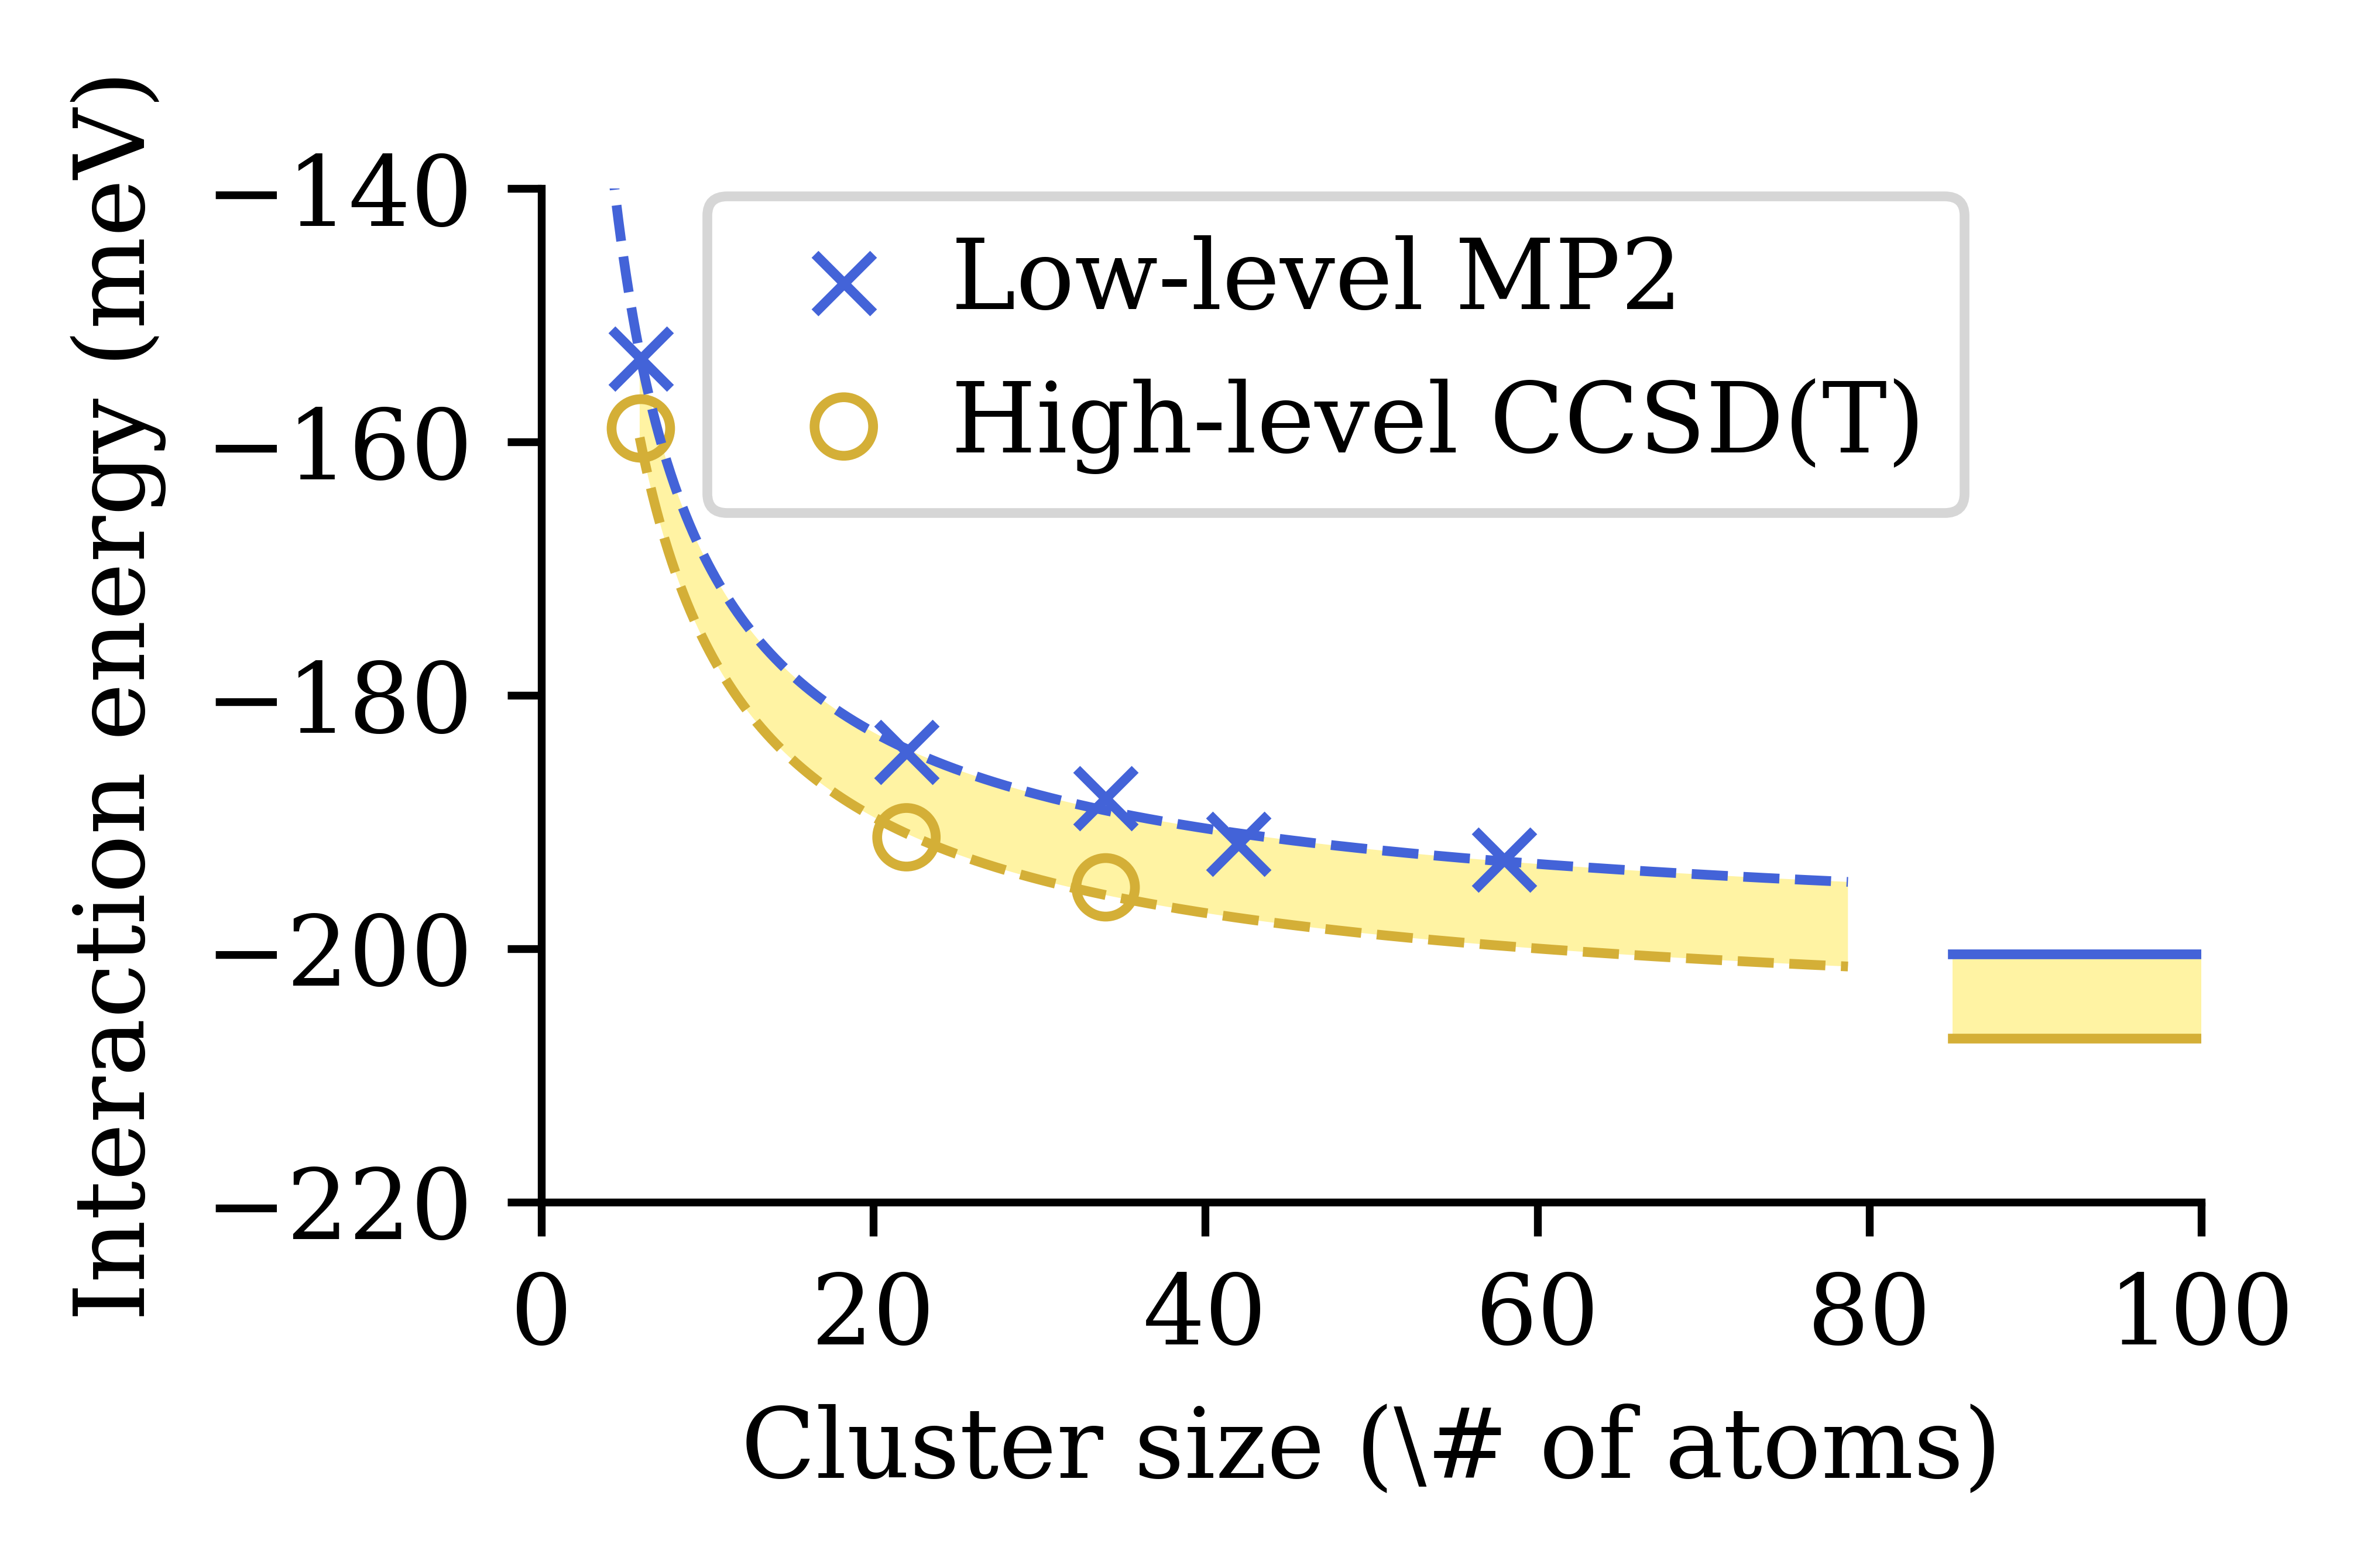

In [21]:
# Schematic of the SKZCAM protocol process which we use in Fig 2 of the main text

mp2_level = np.array(ene_list['MP2_TZQZ'])
atom_size_list = np.array([6, 22, 34, 42, 58, 82, 84, 100, 108])
cc_level = np.array(ene_list['LCCSDT_DZTZ'])

gamma_best = find_co_gamma(ene_list['MP2_TZQZ'])
slope, emp2_infty, r, p, se = linregress([1/(x**(gamma_best)) for x in tot_atom_list[:len(ene_list['MP2_TZQZ'])]],\
    [float(x) for x in ene_list['MP2_TZQZ']])

x = np.linspace(0,150,2000)
y = slope/(x**gamma_best) + emp2_infty


fig, axs = plt.subplots(figsize=(3.25,2),dpi=1200, constrained_layout=True)

for side in ['right','top']:
    axs.spines[side].set_visible(False)

cc_start = 79
cc_end = 1050

axs.fill_between(x[cc_start:cc_end], y[cc_start:cc_end],y[cc_start:cc_end] + ene_final['Cluster CCSD(T)']['DeltaCC'][0],color=color_dict['yellow'],edgecolor=None,alpha=0.4)
axs.plot(x[:cc_end],y[:cc_end],'--',linewidth=1,color=color_dict['blue'])
axs.plot(x[cc_start:cc_end],y[cc_start:cc_end] + ene_final['Cluster CCSD(T)']['DeltaCC'][0] ,'--',linewidth=1,color='#d4af37')

axs.scatter(atom_size_list[:len(mp2_level)], mp2_level, marker = 'x', linewidth=1,color=color_dict['blue'], label='Low-level MP2')
axs.scatter(atom_size_list[:len(cc_level)], cc_level[:len(cc_level)], marker = 'o', color='#d4af37',facecolors='none', linewidth=1,label='High-level CCSD(T)')

extra_spacing = 200

axs.plot([85,110],[emp2_infty,emp2_infty],'-',linewidth=1,color=color_dict['blue'])
axs.fill_between([85,110],[emp2_infty,emp2_infty],np.array([emp2_infty ,emp2_infty]) + ene_final['Cluster CCSD(T)']['DeltaCC'][0],color=color_dict['yellow'],edgecolor=None,alpha=0.4)

axs.plot([85,110],np.array([emp2_infty ,emp2_infty]) + ene_final['Cluster CCSD(T)']['DeltaCC'][0] ,'-',linewidth=1,color='#d4af37')


axs.legend(frameon=True,loc=(0.1,0.68),handletextpad=0.1)

if usetex == True:
    axs.set_ylabel(r'$E_\textrm{int}$ (meV)')
else:
    axs.set_ylabel(r'Interaction energy (meV)')

axs.set_xlabel(r'Cluster size (\# of atoms)')


axs.set_ylim([-220,-140])
axs.set_xlim([0,100])

plt.savefig('Figures/Fig_02.png')

<a id='tables8'></a>
## Table S8 - Final periodic CCSD(T), periodic DMC and cluster CCSD(T) $E_\textrm{ads}$ and their individual contributions

In [22]:
# Compile all of the data in the previous sections to plot out Table S8 (which also contains all of the data in Table 1 of the main text)

# We start with cluster CCSD(T), then periodic CCSD(T) and finally periodic DMC

# Create a DataFrame 'df' using the 'ene_final' dictionary for Cluster CCSD(T) values
df = pd.DataFrame(ene_final['Cluster CCSD(T)']).T

# Rename the columns of the DataFrame 'df' as 'Value' and 'Error'
df.columns = ['Value', 'Error']

# Convert the computational 'Cost' value to kCPUhours (dividing by 1000). Set 'Error' for 'Cost' and 'RAM' to 0 as they are not applicable
df['Value']['Cost'] = df['Value']['Cost'] / 1000
df['Error']['Cost'] = 0
df['Error']['RAM'] = 0

# Round the values in the DataFrame 'df' and convert them to integers
df = df.round().astype(int)

# Print header and the DataFrame 'df' for Cluster CCSD(T) values
print('Cluster CCSD(T)')
print(df)

# Create a DataFrame 'df1' using the 'ene_final' dictionary for Periodic DMC values
df1 = pd.DataFrame(ene_final['Periodic DMC']).T

# Rename the columns of the DataFrame 'df1' as 'Value' and 'Error'
df1.columns = ['Value', 'Error']

# Convert the 'Cost' value to kilojoules (dividing by 1000) and set 'Error' for 'Cost' and 'RAM' to 0
df1['Value']['Cost'] = df1['Value']['Cost'] / 1000
df1['Error']['Cost'] = 0
df1['Error']['RAM'] = 0

# Round the values in the DataFrame 'df1' and convert them to integers
df1 = df1.round().astype(int)

# Print header and the DataFrame 'df1' for Periodic DMC values
print('Periodic DMC')
print(df1)

# Create a DataFrame 'df2' using the 'ene_final' dictionary for Periodic CCSD(T) values
df2 = pd.DataFrame(ene_final['Periodic CCSD(T)']).T

# Rename the columns of the DataFrame 'df2' as 'Value' and 'Error'
df2.columns = ['Value', 'Error']

# Calculate the (approximate) computational 'Cost' value for Periodic CCSD(T) and set 'Error' for 'Cost' and 'RAM' to 0
df2['Value']['Cost'] = 2 * (80 + 6 + 2)
df2['Error']['Cost'] = 0
df2['Error']['RAM'] = 0

# Round the values in the DataFrame 'df2' and convert them to integers
df2 = df2.round().astype(int)

# Print header and the DataFrame 'df2' for Periodic CCSD(T) values
print('Periodic CCSD(T)')
print(df2)

# Save the 'ene_final' dictionary as a NumPy binary file 'methods_eads.npy'
np.save('Data/Misc/methods_eads.npy', ene_final)

# Print the DataFrame 'df2'
print(df2)



Cluster CCSD(T)
                Value  Error
Final            -199     11
EMP2_Bulklimit   -200      5
DeltaCC            -7      3
Delta_geom          8     10
Cost               25      0
RAM                40      0
Periodic DMC
                Value  Error
Final            -188     26
EDMC_2L          -159     14
DeltaDMC_2L-4L     -9     19
DeltaDMC_FSE      -33      5
DeltaLDA_IPFSE      5      0
Delta_geom          8     10
Cost             1079      0
RAM                 0      0
Periodic CCSD(T)
                Value  Error
Final            -193     24
ECCSD(T)_2L      -182     22
DeltaMP2_2L-4L     -6      0
DeltaMP2_core      -8      0
DeltaHF_IPFSE      -5      0
Delta_geom          8     10
Cost              176      0
RAM              3000      0
                Value  Error
Final            -193     24
ECCSD(T)_2L      -182     22
DeltaMP2_2L-4L     -6      0
DeltaMP2_core      -8      0
DeltaHF_IPFSE      -5      0
Delta_geom          8     10
Cost              176     

<a id='tables12'></a>
## Table S12 - Analysis of previous computational work on CO on MgO

In [23]:
# The effect of using different unconverged settings on the interaction energy
# Ideal interaction energy for the fifth rdf cluster.
print('Converged Eint for fifth cluster from SKZCAM protocol:              {0:.0f} meV'.format(ene_list['MP2_DZTZ'][4]))

# Effect of using a small basis set
print('Effect of smaller DZ basis set:                                     {0:.0f} meV <-- a weaker binding of {1:.0f} meV'.format(ene_list['MP2_DZ'][4],ene_list['MP2_DZ'][4] - ene_list['MP2_DZTZ'][4]))
print('Effect of smaller TZ basis set:                                     {0:.0f} meV <-- a weaker binding of {1:.0f} meV'.format(ene_list['MP2_TZ'][4],ene_list['MP2_TZ'][4] - ene_list['MP2_DZTZ'][4]))
print('Effect of smaller QZ basis set:                                     {0:.0f} meV <-- a weaker binding of {1:.0f} meV'.format(ene_list['MP2_QZ'][4],ene_list['MP2_QZ'][4] - ene_list['MP2_DZTZ'][4]))

# Large frozen core, which includes 2s and 2p electrons on the Mg atom
print('Effect of larger frozen core (2s and 2p electrons on Mg frozen):    {0:.0f} meV <-- a weaker binding of {1:.0f} meV'.format(ene_list['MP2_DZTZ_lc'][4],ene_list['MP2_DZTZ_lc'][4] - ene_list['MP2_DZTZ'][4]))

# No BSSE correction
print('Effect of not using counterpoise corrections:                       {0:.0f} meV <-- a stronger binding of {1:.0f} meV'.format(ene_list['MP2_DZTZ_lc_NOCP'][4], np.abs(ene_list['MP2_DZTZ_lc_NOCP'][4] - ene_list['MP2_DZTZ'][4])))

# Computing energy at the smaller cluster size
ene_hf = []
ene_mp2 = []
for k in ['TZ','QZ']:
    ene_hf += [get_eads('Data/MP2_Convergence/{0}/{1}'.format(0,k), code_format='mrcc',typ='hf')*Hartree*1000]
    ene_mp2 += [get_eads('Data/MP2_Convergence/{0}/{1}'.format(0,k), code_format='mrcc',typ='lmp2_corr')*Hartree*1000]
dummy = extrapolate.get_cbs(ene_hf[0],ene_mp2[0],ene_hf[1],ene_mp2[1],X=3,Y=4,family='mixcc',output=False)
print('Effect of using a smaller 3x3x2 quantum cluster:                    {0:.0f} meV <-- a weaker binding of {1:.0f} meV'.format(dummy[-1],np.abs(ene_list['MP2_DZTZ'][4]  - dummy[-1] )))



Converged Eint for fifth cluster from SKZCAM protocol:              -196 meV
Effect of smaller DZ basis set:                                     -122 meV <-- a weaker binding of 74 meV
Effect of smaller TZ basis set:                                     -171 meV <-- a weaker binding of 25 meV
Effect of smaller QZ basis set:                                     -184 meV <-- a weaker binding of 12 meV
Effect of larger frozen core (2s and 2p electrons on Mg frozen):    -165 meV <-- a weaker binding of 31 meV
Effect of not using counterpoise corrections:                       -294 meV <-- a stronger binding of 98 meV
Effect of using a smaller 3x3x2 quantum cluster:                    -184 meV <-- a weaker binding of 12 meV


In [24]:
# Plotting Table S12 on understanding the convergence of previous computational work on the interaction energy of MgO(001)
# This dictionary indicates whether either of the 4 settings are converged. It is not considered converged if their chosen settings are not within 10 meV of the fully converged settings of -199 meV.
computational_work_convergence = {
    'Ugliengo et al.': {
        'Frozen core': 'No',
        'Basis set': 'Yes',
        'BSSE': 'Yes',
        'Cluster Size': 'No (Mg9O9)'
    },
    'Herschend et al.': {
        'Frozen core': 'No',
        'Basis set': 'No (TZ)',
        'BSSE': 'Yes',
        'Cluster Size': 'Yes (Mg18O18)' 
    },
    'Qin et al.': {
        'Frozen core': 'No',
        'Basis set': 'No (DZ)',
        'BSSE': 'Yes',
        'Cluster Size': 'No (Mg9O9)' 
    },
    'Staemmler': {
        'Frozen core': 'Yes',
        'Basis set': 'Yes',
        'BSSE': 'Yes',
        'Cluster Size': 'Yes'
    },
    'Boese et al.': {
        'Frozen core': 'Yes',
        'Basis set': 'Yes',
        'BSSE': 'Yes',
        'Cluster Size': 'Yes'
    },
    'Li et al.': {
        'Frozen core': 'N/A' ,
        'Basis set': 'No [6-311+G(2df)]',
        'BSSE': 'N/A',
        'Cluster Size': 'Yes' 
    },
    'Heuser et al.': {
        'Frozen core': 'N/A' ,
        'Basis set': 'No [TZ]',
        'BSSE': 'No',
        'Cluster Size': 'No (Mg9O9 without embedding)' 
    },
    'Mazheika and Levchenko': {
        'Frozen core': 'No' ,
        'Basis set': 'No [DZ and TZ]',
        'BSSE': 'Yes',
        'Cluster Size': 'No (Mg9O9 with electrostatic embedding)' 
    },
    'Alessio et al.': {
        'Frozen core': 'Yes',
        'Basis set': 'Yes',
        'BSSE': 'Yes',
        'Cluster Size': 'Yes'
    },
    'Mitra et al.': {
        'Frozen core': 'Yes',
        'Basis set': 'No (TZ)',
        'BSSE': 'No',
        'Cluster Size': 'Yes'
    }
}

df = pd.DataFrame(computational_work_convergence).T
df

,Frozen core,Basis set,BSSE,Cluster Size
Ugliengo et al.,No,Yes,Yes,No (Mg9O9)
Herschend et al.,No,No (TZ),Yes,Yes (Mg18O18)
Qin et al.,No,No (DZ),Yes,No (Mg9O9)
Staemmler,Yes,Yes,Yes,Yes
Boese et al.,Yes,Yes,Yes,Yes
Li et al.,N/A,No [6-311+G(2df)],N/A,Yes
Heuser et al.,N/A,No [TZ],No,No (Mg9O9 without embedding)
Mazheika and Levchenko,No,No [DZ and TZ],Yes,No (Mg9O9 with electrostatic embedding)
Alessio et al.,Yes,Yes,Yes,Yes
Mitra et al.,Yes,No (TZ),No,Yes


<a id='tables13'></a>
## Table S13 - Computation of zero-point energy and thermal contribution terms to convert $H_\textrm{ads}$ to $E_\textrm{ads}$

In [25]:
# Compiling data for Table S13
# Define a list 'params' with temperature and degrees of freedom values of the molecule
params = [61, 1]  # [ Temperature, degrees of freedom = 3N-5 ] 
#Temperature given as average between studies by Dohnalek et al. and Wichtendahl et al.

# Initialize a nested dictionary 'thermal_ene_contributions' to store various thermal energy contributions for the 6 studied DFT functional
thermal_ene_contributions = {y: {x: 0 for x in dft_functionals} for y in ['ZPE', 'Eth', 'RT', 'Ecor']}

# Iterate over each DFT functional
for i in dft_functionals:
    # Read vibrational frequencies from OUTCAR files
    a, b = read_vib_freq('Data/DFT/Vib_Energy/{0}/AD_SLAB/OUTCAR'.format(i)) # CO on MgO
    c, d = read_vib_freq('Data/DFT/Vib_Energy/{0}/AD/OUTCAR'.format(i)) # CO gas-phase molecule

    # Calculate thermal and zero-point corrections as well as RT term for adsorbate and adsorbate on slab
    ene_ad, eth_ad, zpe_ad, kT = get_quasi_rrho(a, b, params[0])
    ene_ad_slab, eth_ad_slab, zpe_ad_slab, kT = get_quasi_rrho(c, d, params[0])

    # Store thermal energy contributions in the nested dictionary 'thermal_ene_contributions'
    thermal_ene_contributions['ZPE'][i] = zpe_ad_slab - zpe_ad
    thermal_ene_contributions['Eth'][i] = eth_ad_slab - eth_ad
    thermal_ene_contributions['Ecor'][i] = ene_ad - ene_ad_slab + kT
    thermal_ene_contributions['RT'][i] = kT

# Create a DataFrame 'df' using the 'thermal_ene_contributions' dictionary
df = pd.DataFrame(thermal_ene_contributions)

# Round the values in the DataFrame 'df' and convert them to integers
df = df.round().astype(int)

# Open a file 'thermal_corr.txt' in write mode
f = open('Data/Misc/thermal_corr.txt', 'w')

# Write average values of thermal energy contributions to the file
f.write('{0} Ecor\n'.format(np.average([thermal_ene_contributions['Ecor'][x] for x in thermal_ene_contributions['Ecor']])))
f.write('{0} ZPE\n'.format(np.average([thermal_ene_contributions['ZPE'][x] for x in thermal_ene_contributions['Ecor']])))
f.write('{0} Eth\n'.format(np.average([thermal_ene_contributions['Eth'][x] for x in thermal_ene_contributions['Ecor']])))
f.write('{0} RT'.format(np.average([thermal_ene_contributions['RT'][x] for x in thermal_ene_contributions['Ecor']])))

# Close the file 'thermal_corr.txt'
f.close()

# Calculate the average thermal correction and zero-point correction across the 6 functionals
thermal_correction = np.average([thermal_ene_contributions['Ecor'][x] for x in thermal_ene_contributions['Ecor']])
rt = np.average([thermal_ene_contributions['RT'][x] for x in thermal_ene_contributions['Ecor']])

# Print the DataFrame 'df'
print(df)


                ZPE  Eth  RT  Ecor
01_PBE-D2-Ne    -31    6   5    30
02_revPBE-D4    -28    5   5    28
03_vdW-DF       -28    5   5    28
04_rev-vdW-DF2  -32    6   5    31
05_PBE0-D4      -30    5   5    30
06_B3LYP-D2-Ne  -29    5   5    29


<a id='fig3'></a>
## Figure 3 and S1 - Converting previous experiment $H_\textrm{ads}$ or $E_\textrm{act}$ (for TPD) to $E_\textrm{ads}$

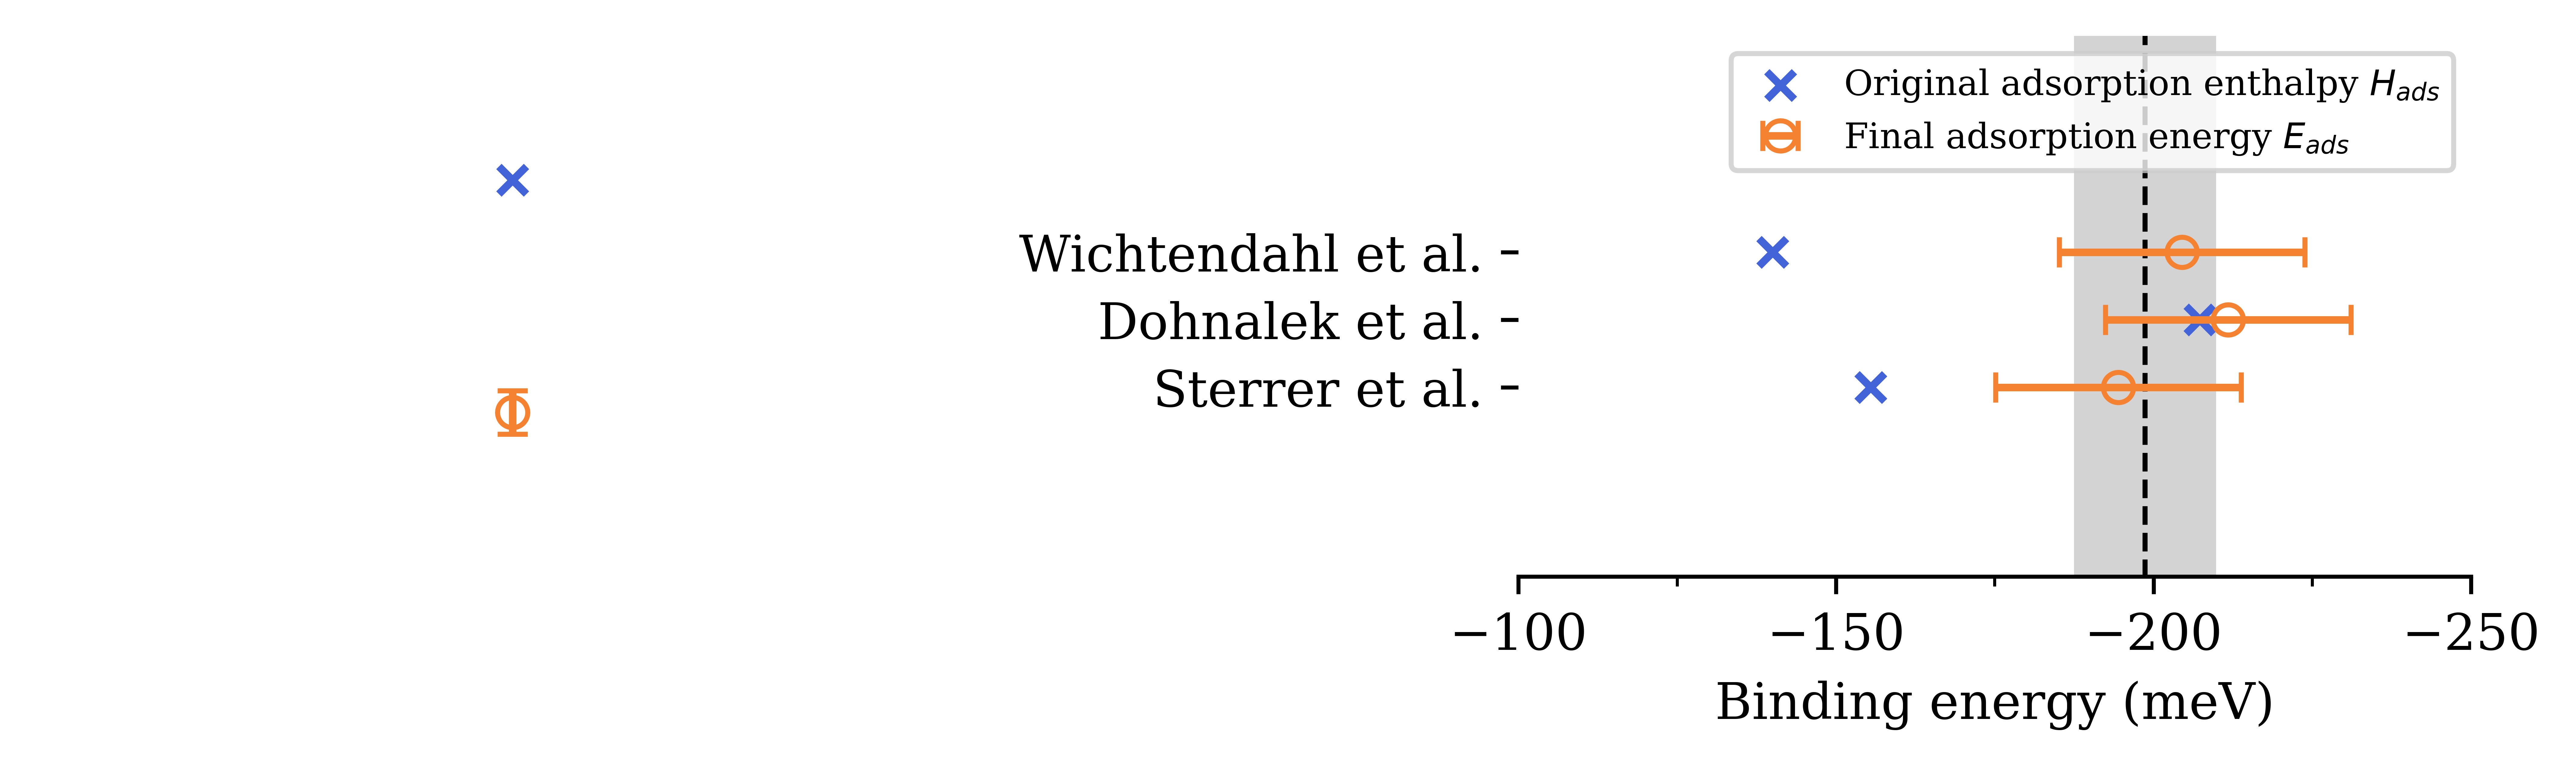

In [26]:
# Plotting Figure 3 of the main text

# Dictionary of Eact from the three TPD experiments
experimental_eact = {
    'Wichtendahl et al.': [-140,'Thermal programmed desorption',1999,'Eact, nu=13, low 0.3 ML coverage'],
    'Dohnalek et al.': [-20*kjmol_to_meV,'Thermal programmed desorption',2001,'Eact, nu=15, dilute limit extrapolation'],
    'Sterrer et al.': [-15*kjmol_to_meV,'Thermal programmed desorption',2006,'Eact, nu=13, high CO coverage']
}

# Dictionary of Eads from the three TPD experiments by adding only a thermal correction but not the correction for pre-exponential factor.
experimental_eads = {
    'Wichtendahl et al.': [-16.9*kjmol_to_meV - thermal_correction,'Thermal programmed desorption',1999,'Campbell and Sellers, nu=13.8, low 0.3 ML coverage'],
    'Dohnalek et al.': [-17.6*kjmol_to_meV - thermal_correction,'Thermal programmed desorption',2001,'Campbell and Sellers, nu=13.8, low 0.3 ML coverage'],
    'Sterrer et al.': [-15*kjmol_to_meV - 0.8*2.3*rt - thermal_correction,'Thermal programmed desorption',2006,'nu=13.8 corrected, high CO coverage']
}


# Plot the figure
fig, axs = plt.subplots(1,2,figsize=(7,2),dpi=1200,constrained_layout=True)


axs[1].plot([ene_final['Cluster CCSD(T)']['Final'][0],ene_final['Cluster CCSD(T)']['Final'][0]],[1970,2025],'--',color='k',linewidth=1)
axs[1].fill_betweenx([1970,2025],[ene_final['Cluster CCSD(T)']['Final'][0] - ene_final['Cluster CCSD(T)']['Final'][1],ene_final['Cluster CCSD(T)']['Final'][0] - ene_final['Cluster CCSD(T)']['Final'][1]],[ene_final['Cluster CCSD(T)']['Final'][0] + ene_final['Cluster CCSD(T)']['Final'][1],ene_final['Cluster CCSD(T)']['Final'][0] + ene_final['Cluster CCSD(T)']['Final'][1]],color=color_dict['grey'],linewidth=1,edgecolor='none',alpha=0.5)

axs[1].scatter([experimental_eact['Wichtendahl et al.'][0],experimental_eact['Dohnalek et al.'][0],experimental_eact['Sterrer et al.'][0]],[1998,2000.5,2003],s=30, color=color_dict['blue'], marker='x',label=r'Original adsorption enthalpy $H_{ads}$')
axs[1].errorbar([experimental_eads['Wichtendahl et al.'][0],experimental_eads['Dohnalek et al.'][0],experimental_eads['Sterrer et al.'][0]],[1998,2000.5,2003],xerr=1.6*2.3*rt,fmt='o',markersize=6,capsize=3,color=color_dict['orange'],markerfacecolor='none',label=r'Final adsorption energy $E_{ads}$')



axs[1].set_xlabel(r'Binding energy (meV)')

axs[1].spines['left'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].spines['top']. set_visible(False)

axs[1].set_ylim([2004.5,1997])
axs[1].set_xlim([-100,-250])


axs[1].xaxis.set_major_locator(MultipleLocator(50))
axs[1].xaxis.set_minor_locator(MultipleLocator(25))

axs[1].set_yticks([1998,2000.5,2003])
axs[1].set_yticklabels([r'Wichtendahl et al.','Dohnalek et al.', 'Sterrer et al.'])



axs[0].spines['left'].set_visible(False)
axs[0].spines['bottom']. set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].spines['top']. set_visible(False)
axs[0].set_xticks([])
axs[0].set_yticks([])


axs[0].scatter([1998],[experimental_eact['Wichtendahl et al.'][0]],s=30, color=color_dict['blue'], marker='x')
axs[0].errorbar([1998],[experimental_eads['Wichtendahl et al.'][0]],yerr=6,fmt='o',markersize=6,capsize=3,color=color_dict['orange'],markerfacecolor='none')
axs[0].set_ylim([-250,-100])

if usetex == False:
    axs[1].set_ylim([2010,1990])
    axs[1].legend(fontsize=7)

plt.savefig('Figures/Fig_03.png')


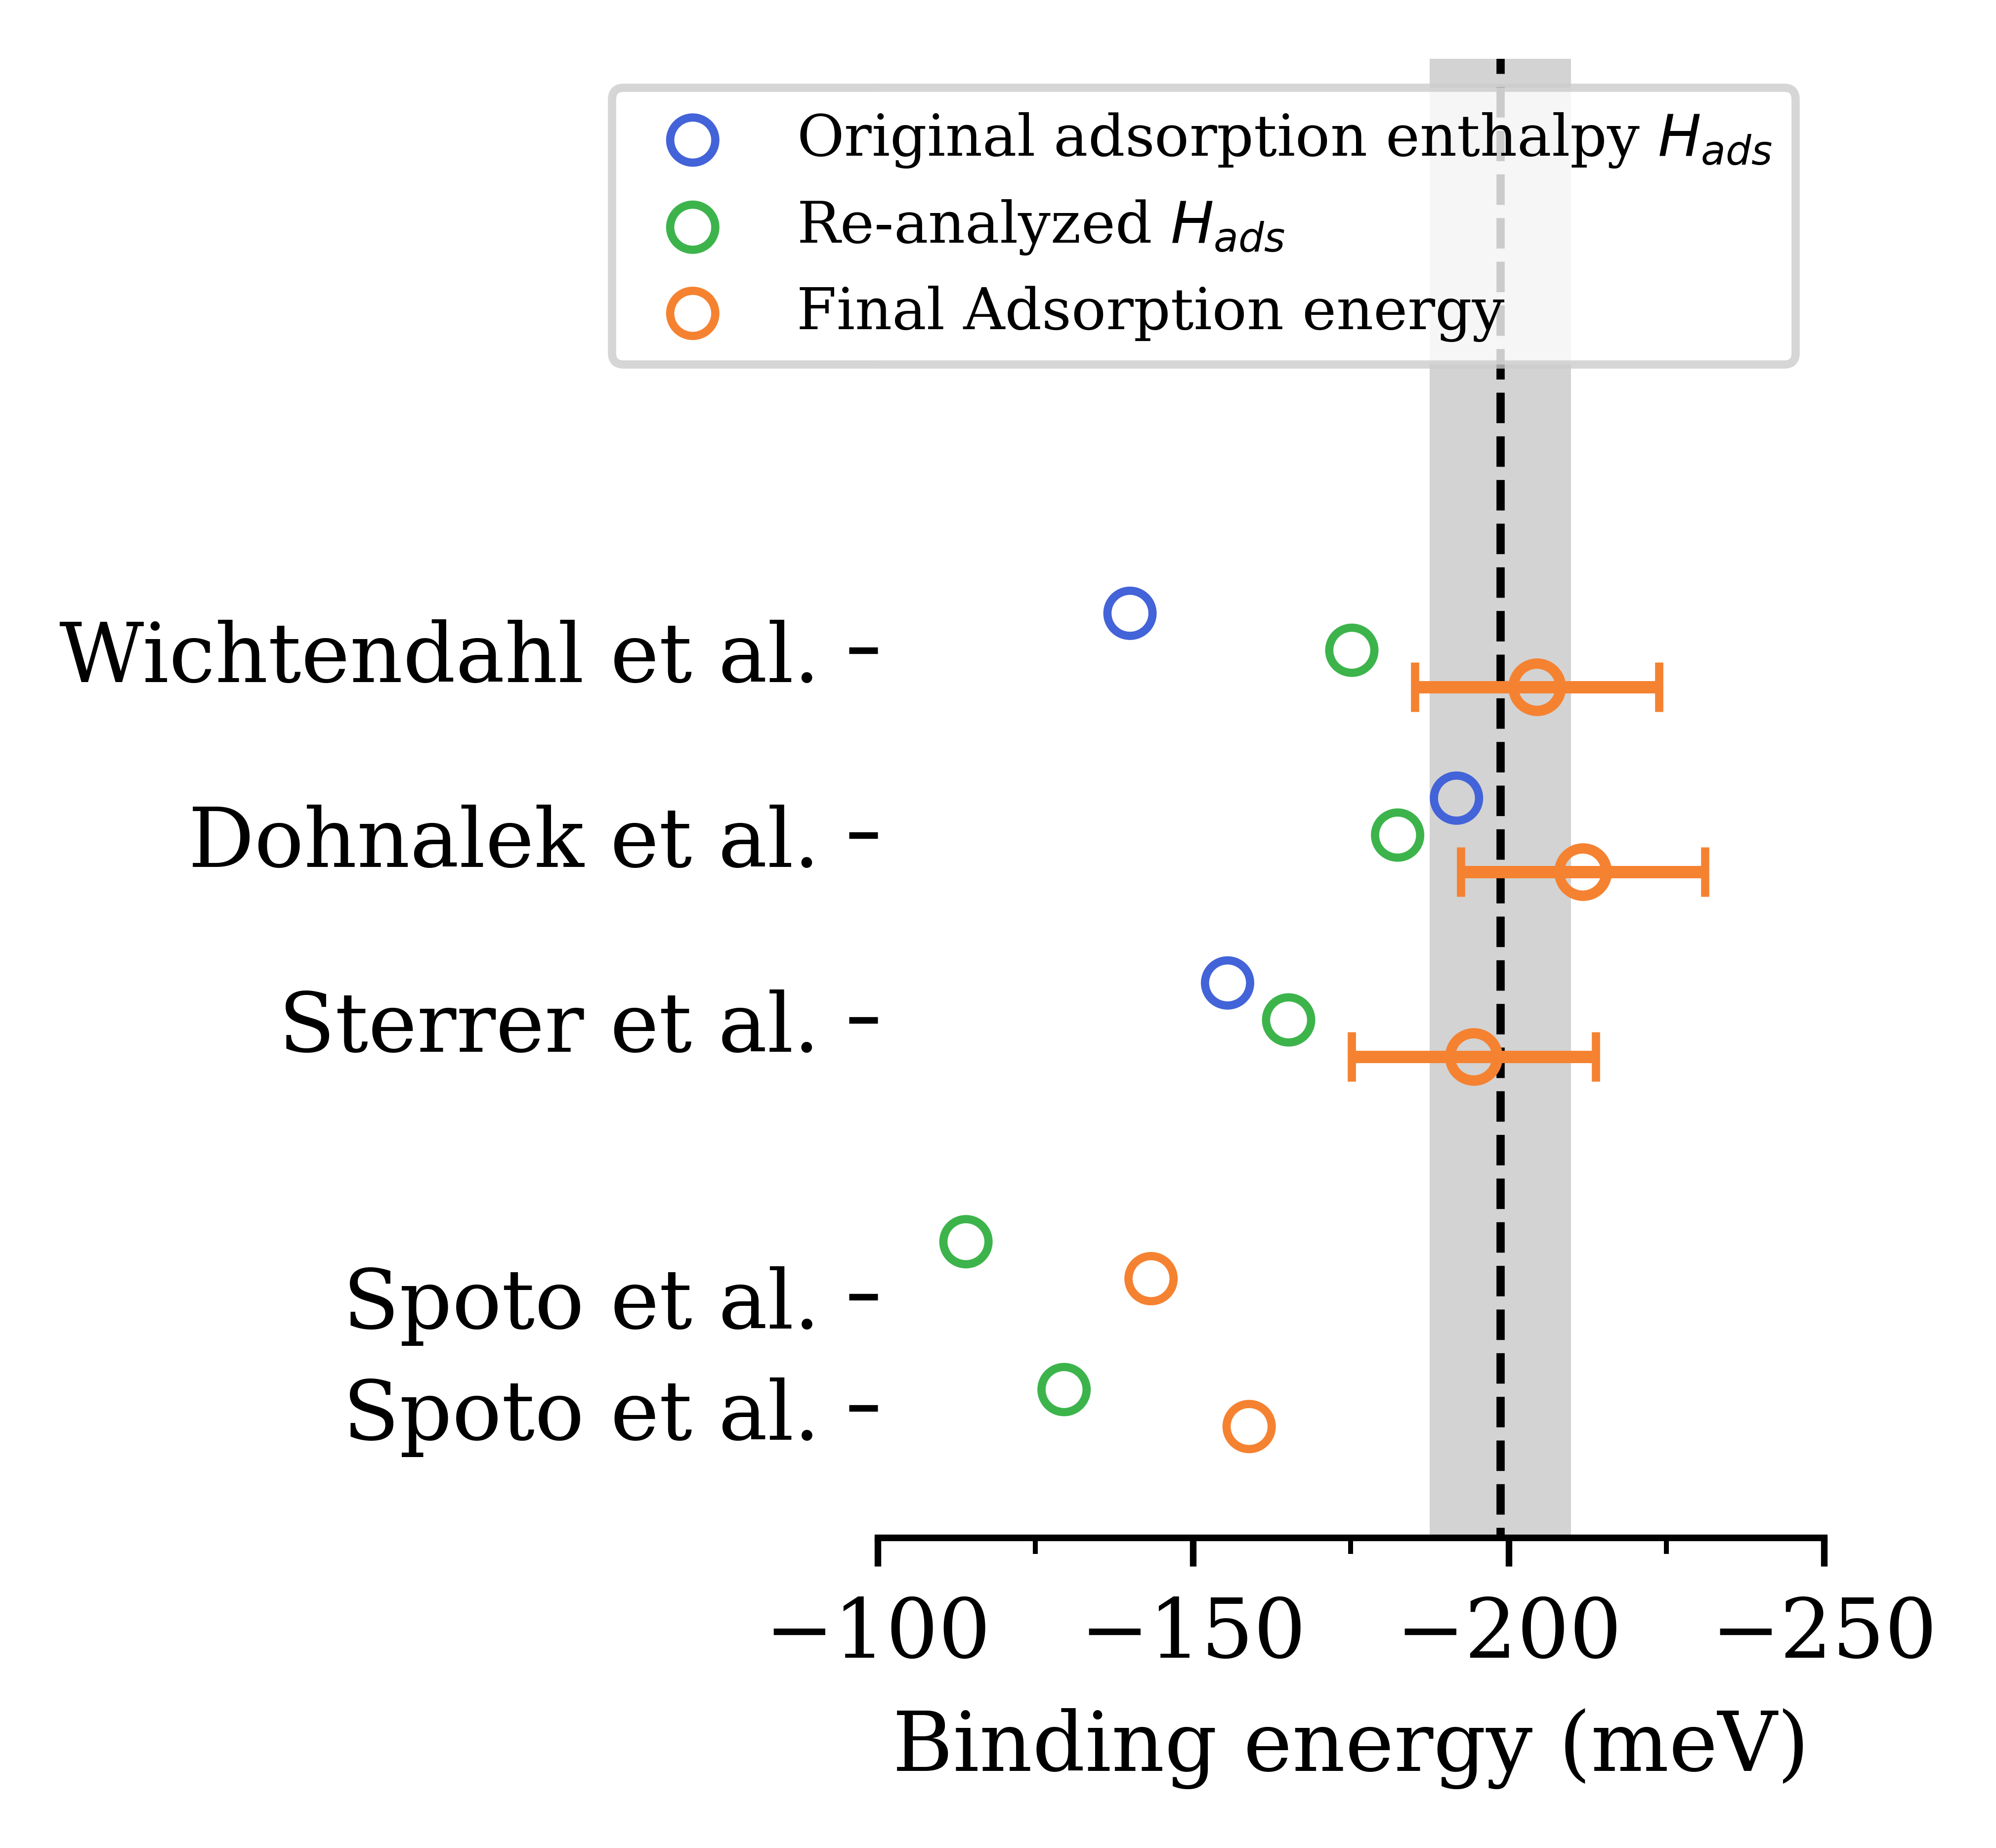

In [27]:
# Plotting Figure S1 of the main text

# Dictionary of activation energy Eact from the three TPD experiments
experimental_eact = {
    'Wichtendahl et al.': [-140,'Thermal programmed desorption',1999,'Eact, nu=13, low 0.3 ML coverage'],
    'Dohnalek et al.': [-18.5*kjmol_to_meV,'Thermal programmed desorption',2001,'Eact, nu=15, low 0.125 ML coverage'],
    'Sterrer et al.': [-15*kjmol_to_meV,'Thermal programmed desorption',2006,'Eact, nu=13, high CO coverage']
}
# Dictionary of adsorption enthalpy Hads from the three TPD experiments and 2 FTIR experiments. Adsorption enthalpy of Wichtendahl et al. and Dohnalek et al. taken from Campbell and Sellers, which also corrected for the pre-exponential factor.
experimental_hads = {
    'Wichtendahl et al.': [-16.9*kjmol_to_meV,'Thermal programmed desorption',1999,'Campbell and Sellers, nu=13.8, low 0.3 ML coverage'],
    'Dohnalek et al.': [-17.6*kjmol_to_meV,'Thermal programmed desorption',2001,'Campbell and Sellers, nu=13.8, low 0.3 ML coverage'],
    'Spoto et al.1': [-11*kjmol_to_meV,'FTIR spectroscopy',2003,'MgO smoke'],
    'Spoto et al.2': [-12.5*kjmol_to_meV,'FTIR spectroscopy',2004,'MgO smoke'],
    'Sterrer et al.': [-15*kjmol_to_meV - 0.8*2.3*rt,'Thermal programmed desorption',2006,'nu=13.8 corrected, high CO coverage']
}
# Dictionary of adsorption energies
experimental_eads = {
    'Wichtendahl et al.': [-16.9*kjmol_to_meV - thermal_correction,'Thermal programmed desorption',1999,'Campbell and Sellers, nu=13.8, low 0.3 ML coverage'],
    'Dohnalek et al.': [-17.6*kjmol_to_meV - thermal_correction,'Thermal programmed desorption',2001,'Campbell and Sellers, nu=13.8, low 0.3 ML coverage'],
    'Spoto et al.1': [-11*kjmol_to_meV - thermal_correction,'FTIR spectroscopy',2003,'MgO smoke'],
    'Spoto et al.2': [-12.5*kjmol_to_meV - thermal_correction,'FTIR spectroscopy',2004,'MgO smoke'],
    'Sterrer et al.': [-15*kjmol_to_meV - 0.8*2.3*rt - thermal_correction,'Thermal programmed desorption',2006,'nu=13.8 corrected, high CO coverage']
}

# Plot the figure
fig, axs = plt.subplots(figsize=(3.25,3),dpi=1200, sharey=True,constrained_layout=True)

# The SKZCAM protocol reference number
axs.plot([ene_final['Cluster CCSD(T)']['Final'][0],ene_final['Cluster CCSD(T)']['Final'][0]],[1970,2025],'--',color='k',linewidth=1)
axs.fill_betweenx([1970,2025],[ene_final['Cluster CCSD(T)']['Final'][0] - ene_final['Cluster CCSD(T)']['Final'][1],ene_final['Cluster CCSD(T)']['Final'][0] - ene_final['Cluster CCSD(T)']['Final'][1]],[ene_final['Cluster CCSD(T)']['Final'][0] + ene_final['Cluster CCSD(T)']['Final'][1],ene_final['Cluster CCSD(T)']['Final'][0] + ene_final['Cluster CCSD(T)']['Final'][1]],color=color_dict['grey'],linewidth=1,edgecolor='none',alpha=0.5)

axs.scatter([experimental_eact['Wichtendahl et al.'][0],experimental_eact['Dohnalek et al.'][0],experimental_eact['Sterrer et al.'][0]],[1997.5,2000,2002.5],s=30, color=color_dict['blue'], facecolor='none',label=r'Original adsorption enthalpy $H_{ads}$')
axs.scatter([experimental_hads['Wichtendahl et al.'][0],experimental_hads['Dohnalek et al.'][0],experimental_hads['Sterrer et al.'][0]],[1998,2000.5,2003],s=30, color=color_dict['green'], facecolor='none',label=r'Re-analyzed $H_{ads}$') 
axs.scatter([experimental_eads['Wichtendahl et al.'][0],experimental_eads['Dohnalek et al.'][0],experimental_eads['Sterrer et al.'][0]],[1998.5,2001,2003.5],s=30, color=color_dict['orange'], facecolor='none',label=r'Final Adsorption energy') 
axs.errorbar([experimental_eads['Wichtendahl et al.'][0],experimental_eads['Dohnalek et al.'][0],experimental_eads['Sterrer et al.'][0]],[1998.5,2001,2003.5],xerr=1.6*2.3*rt,fmt='o',markersize=6,capsize=3,color=color_dict['orange'],markerfacecolor='none')



axs.scatter([experimental_hads['Spoto et al.1'][0],experimental_hads['Spoto et al.2'][0]],[2006,2008],s=30, color=color_dict['green'], facecolor='none')
axs.scatter([experimental_eads['Spoto et al.1'][0],experimental_eads['Spoto et al.2'][0]],[2006.5,2008.5],s=30, color=color_dict['orange'], facecolor='none')

axs.set_xlabel(r'Binding energy (meV)')

axs.spines['left'].set_visible(False)
axs.spines['right'].set_visible(False)
axs.spines['top']. set_visible(False)

axs.set_ylim([2010,1995])
axs.set_xlim([-100,-250])

if usetex == False:
    axs.set_ylim([2010,1990])
    axs.legend(fontsize=7)


axs.xaxis.set_major_locator(MultipleLocator(50))
axs.xaxis.set_minor_locator(MultipleLocator(25))

axs.set_yticks([1998,2000.5,2003,2006.75,2008.25])
axs.set_yticklabels([r'Wichtendahl et al.','Dohnalek et al.','Sterrer et al.','Spoto et al.','Spoto et al.',])


plt.savefig('Figures/Fig_S1.png')

<a id='tables14'></a>
## Table S14 - Final best estimate of TPD experimental adsorption energies

In [28]:
# Plotting Table S14 on the final TPD adsorption energies of the three experiments

# Dictionary of adsorption energies and CO coverage
experimental_eads = {
    'Wichtendahl et al.': [-16.9*kjmol_to_meV - thermal_correction,'Thermal programmed desorption',1999,'low 0.3 ML coverage'],
    'Dohnalek et al.': [-17.6*kjmol_to_meV - thermal_correction,'Thermal programmed desorption',2001,'low 0.3 ML coverage'],
    'Sterrer et al.': [-15*kjmol_to_meV - 0.8*2.3*rt - thermal_correction,'Thermal programmed desorption',2006,'high CO coverage']
}

df = pd.DataFrame(experimental_eads).T
df = df.reset_index()
df.columns = ['Reference','Eads (meV)','Method','Year','CO Coverage']
df = df[['Reference','Eads (meV)','CO Coverage']]
df['Eads (meV)'] = [round(x) for x in df['Eads (meV)']]

# Get best estimate as average of Wichtendahl et al. and Dohnalek et al.
best_expt = np.average([experimental_eads['Wichtendahl et al.'][0],experimental_eads['Dohnalek et al.'][0]])

# Plot table
df


,Reference,Eads (meV),CO Coverage
0,Wichtendahl et al.,-204,low 0.3 ML coverage
1,Dohnalek et al.,-212,low 0.3 ML coverage
2,Sterrer et al.,-194,high CO coverage


In [29]:
# Best experimental estimate
print(f"Best experimental estimate: {round(best_expt)} +- {round(1.6*2.3*rt)} meV")

Best experimental estimate: -208 +- 19 meV


<a id='tables15'></a>
## Table S15 - Effect of CO coverage on $E_\textrm{ads}$

In [30]:
# Plotting Table S15 for effect of CO coverage on adsorption energy

# Initialize a nested dictionary 'eads_dft_coverage' to store adsorption energy values for different CO coverages
eads_dft_coverage_conv = {
    '0.125': {
        # 'Supercell Size': '4x4' ,
        'CO coverage': '0.250' ,
        'Eads': 0,
        'Diff': 0
    },
    '0.250': {
        # 'Supercell Size': '2x2' ,
        'CO coverage': '0.125' ,
        'Eads': 0,
        'Diff': 0
    },
}

# Iterate over each CO coverage and get adsorption energy
for i in ['0.125','0.250']:
    ad_slab = find_energy('Data/DFT/Convergence/Coverage/{0}/AD_SLAB/OUTCAR'.format(i),code_format='vasp')
    ad =  find_energy('Data/DFT/Convergence/Coverage/{0}/AD/OUTCAR'.format(i),code_format='vasp')
    slab = find_energy('Data/DFT/Convergence/Coverage/{0}/SLAB/OUTCAR'.format(i),code_format='vasp')

    eads = (ad_slab-ad-slab)*1000
    if i == '0.125':
        eads0 = eads
    
    eads_dft_coverage_conv[i]['Eads'] = eads
    eads_dft_coverage_conv[i]['Diff'] = (eads - eads0)

df = pd.DataFrame(eads_dft_coverage_conv).T
df['Eads'] = df['Eads'].apply(lambda x: round(x))
df['Diff'] = df['Diff'].apply(lambda x: round(x))
df

,CO coverage,Eads,Diff
0.125,0.250,-266,0
0.250,0.125,-265,1
